In [5]:
import clmm
from clmm import Cosmology
import numpy as np
import math
import matplotlib.pyplot as plt

import sys  #
import h5py #
import matplotlib.pyplot as plt  #
import numpy as np  #T
import random  #
import pandas  #
from scipy import integrate, signal   #T
from scipy.stats import binned_statistic  #T
from scipy.stats import norm   #T
from scipy.special import erf   #T
import astropy   
import astropy.constants as const
import astropy.units as units
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import FlatwCDM
from IPython.display import clear_output
import os
import corner
import emcee
from multiprocessing import Pool
from matplotlib.pyplot import cm
import time as pytime

cosmo = Cosmology(H0=71.0, Omega_dm0=0.2248, Omega_b0=0.2648 - 0.2248, Omega_k0=0.0)
cosmo_astropy = FlatwCDM(H0=71, Om0=0.2648, Ob0=0.04479, w0=-1.000000)

In [44]:
from scipy.interpolate import InterpolatedUnivariateSpline
def compute_delta_sigma_4theta(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=10000, delta_mdef=200):
    
    ### DEFINING INTEGRALS:
    r_arr = np.linspace(0.01, 3*np.max(r), sample_N)
    sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr
    f = InterpolatedUnivariateSpline(r_arr, (r_arr**3)*sigma_0_arr*eta_0_arr, k=3)  # k=3 order of spline
    integral_vec = np.vectorize(f.integral)
    ###
    
    ### ACTUAL COMPUTATION:
    I_1 = (3/(r**4)) * integral_vec(0, r)
    sigma_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    #eta_0 = np.gradient(np.log(sigma_0),r)
    eta_0_interpolation_func = InterpolatedUnivariateSpline(r_arr, eta_0_arr)
    eta_0 = eta_0_interpolation_func(r) 
    
    
    return np.array((ell/4.0)*(2*I_1 - sigma_0*eta_0))

def compute_delta_sigma_const(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=10000 ,delta_mdef=200):

    ### DEFINING INTEGRALS:
    r_arr = np.linspace(0.01, 3*np.max(r), sample_N)
    sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr
    f = InterpolatedUnivariateSpline(r_arr, sigma_0_arr*eta_0_arr/r_arr, k=3)  # k=3 order of spline
    integral_vec = np.vectorize(f.integral)
    ###
    
    ### ACTUAL COMPUTATION:
    I_2 = integral_vec(r, np.inf)
    sigma_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    #eta_0 = np.gradient(np.log(sigma_0), r)*r
    eta_0_interpolation_func = InterpolatedUnivariateSpline(r_arr, eta_0_arr)
    eta_0 = eta_0_interpolation_func(r) 
    
    return np.array((ell/4.0)*(2*I_2 - sigma_0*eta_0))


def compute_delta_sigma_excess(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=10000, delta_mdef=200):
    r_arr = np.linspace(0.01, 3*np.max(r), sample_N)
    sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr  
    eta_0_interpolation_func = InterpolatedUnivariateSpline(r_arr, eta_0_arr)
    eta_0 = eta_0_interpolation_func(r) 
    
    
    
    ## e^2 shenanigans:
    d_eta_0_arr_by_d_r = np.gradient(eta_0_arr,r_arr)*r_arr
    d_eta_0_arr_by_d_r_interpolation_func = InterpolatedUnivariateSpline(r_arr, d_eta_0_arr_by_d_r)
    d_eta_0_by_d_r = d_eta_0_arr_by_d_r_interpolation_func(r)
    
    correction_factor_arr = ((ell)**2*((1/8)*eta_0_arr + (1/16)*d_eta_0_arr_by_d_r + (1/16)*eta_0_arr**2))
    integrand = InterpolatedUnivariateSpline(r_arr, r_arr*sigma_0_arr*correction_factor_arr)
    
    integral_vec = np.vectorize(integrand.integral)
    ##
    
    ### ACTUAL COMPUTATION:
    I = (2/r**2)*integral_vec(0, r)
    
    #q=np.sqrt(2/(1+ell) - 1)
    
    s = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    
    correction_factor = ((ell)**2*((1/8)*eta_0 + (1/16)*d_eta_0_by_d_r + (1/16)*eta_0**2))
    ds_ell_square_correction = I - s*correction_factor

    
    return clmm.compute_excess_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True) + ds_ell_square_correction

In [39]:
## With emcee:
def log_likelihood_monopole(ds_mono,ds_mono_err, r_mono,params):
    
    sigma_c = 3.77988e+15
    z_cl=0.47
    z_gal=0.8
    mdelta,cdelta,ell = params  # km/s
    
    ds_data = ds_mono
    
    #model:
    ds_model = compute_delta_sigma_excess(ell, r_mono, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)#/sigma_c

    # Gaussian likelihood:
    #sigma = np.full(len(r_mono), ds_model*0.01) 
    sigma = ds_mono_err
    term1 = -0.5*np.sum(np.log(2*np.pi*(sigma**2)))
    chi2 = ((ds_data - ds_model)**2 / (sigma)**2)
    term2 = -0.5*np.sum(chi2)


    return term1+term2

def log_likelihood_quadrupole_4theta(ds_quad_4theta,ds_quad_4theta_err, r_quad,params):
    sigma_c = 3.77988e+15
    z_cl=0.47
    z_gal=0.8
    mdelta,cdelta,ell = params  # km/s
    
    ds_data = ds_quad_4theta
    
    #model:
    ds_model = compute_delta_sigma_4theta(ell, r_quad, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)#/sigma_c
    
    # Gaussian likelihood:
    #sigma = np.full(len(r_quad), ds_model*0.05) 
    sigma = ds_quad_4theta_err
    term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
    chi2 = ((ds_data - ds_model)**2 / sigma**2)
    term2 = -0.5*np.sum(chi2)

    return term1+term2

def log_likelihood_quadrupole_const(ds_quad_const,ds_quad_const_err, r_quad,params):
    sigma_c = 3.77988e+15
    z_cl=0.47
    z_gal=0.8
    mdelta,cdelta,ell = params  # km/s
    
    ds_data = ds_quad_const
    
    #model:
    ds_model = compute_delta_sigma_const(ell, r_quad, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)#/sigma_c
    
    # Gaussian likelihood:
    #sigma = np.full(len(r_quad), ds_model*0.05) 
    sigma = ds_quad_const_err
    term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
    chi2 = ((ds_data - ds_model)**2 / sigma**2)
    term2 = -0.5*np.sum(chi2)

    return term1+term2

def priors(params, limits):
    
    a,b,c = params
    if (a < limits[0][0] or a > limits[0][1]):        #mdelta
        return -np.inf
    elif (b < limits[1][0] or b > limits[1][1]):      #cdelta
        return -np.inf
    elif (c < limits[2][0] or c > limits[2][1]):      #ell
        return -np.inf
    #elif (d < limits[3][0] or d > limits[3][1]):      #theta_e
    #    return -np.inf

    else:
        return 0.0
    

def log_posterior(params,gamma1, gamma2, x_arcsec, y_arcsec, sigma_c = 3.77988e+15):
    
    mdelta,cdelta,ell = params    
    
    #rotation:
    #theta_e = theta_e*np.pi/180.0 # in radians
    #gamma1,gamma2,x_arcsec,y_arcsec = halo_rotation(gamma1,gamma2,x_arcsec,y_arcsec,theta_e)
    
    #Prepare the data vector -> estimate delta sigma expansion terms
    global run_estimator
    global ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad
    if run_estimator == True:
        run_estimator = False
        ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15)
    

    #Evaluate the prior:
    prior=priors(params, limits)
    
    #Avoid likelihood evaluation when prior is -infinity:
    if prior == -np.inf:
        lnP = -np.inf
    else:
        
        lnP = prior + log_likelihood_monopole(ds_mono,ds_mono_err, r_mono,params) + log_likelihood_quadrupole_const(ds_quad_const,ds_quad_const_err, r_quad,params) + log_likelihood_quadrupole_4theta(ds_quad_4theta, ds_quad_4theta_err, r_quad,params)
        #log_likelihood_monopole(ds_mono,ds_mono_err, r_mono,params) +
    
    # safeguard against NaNs:
    if np.isnan(lnP):
        return -np.inf
    else:
        return lnP
    
#---------------------------------------------DIRECT---------------------------------------------------#

def log_likelihood_direct(gammat, r_mpc, sigma_c,params):
    
    #sigma_c = 3.77988e+15
    #z_cl=0.47
    #z_gal=0.8
    mdelta,cdelta,ell = params  # km/s
    
    gt_data = gammat
    
    
    gt_model = clmm.compute_excess_surface_density(r_mpc, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)/sigma_c
    # Gaussian likelihood:
    #sigma = np.full(len(r_quad), ds_model*0.05) 
    gt_sigma=0.001
    sigma = np.full(len(gt_data), gt_sigma)
    term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
    chi2 = ((gt_data - gt_model)**2 / sigma**2)
    term2 = -0.5*np.sum(chi2)

    return term1+term2
    
def log_posterior_direct(params,gamma1, gamma2, x_arcsec, y_arcsec, sigma_c = 3.77988e+15):
    
    mdelta,cdelta,ell = params

    #rotation:
    #theta_e = theta_e*np.pi/180.0 # in radians
    #gamma1,gamma2,x_arcsec,y_arcsec = halo_rotation(gamma1,gamma2,x_arcsec,y_arcsec,theta_e)

    #Evaluate the prior:
    prior=priors(params, limits)

    
    #Avoid likelihood evaluation when prior is -infinity:
    if prior == -np.inf:
        lnP = -np.inf
    else:
        q = np.sqrt((1-ell)/(1+ell))
        theta = np.arctan2(q*y_arcsec, x_arcsec)
        sigma_c = cosmo.eval_sigma_crit(0.47,0.8)
        gammat = -1*gamma1*np.cos(2*theta) - gamma2*np.sin(2*theta)
        r = np.sqrt((x_arcsec)**2*q + (y_arcsec)**2/q)#*np.sqrt(q)
        r_mpc = r*cosmo.eval_da(z_cl) * np.pi/180.0 * 1/3600#0.00588784182755241#
        lnP = prior + log_likelihood_direct(gammat, r_mpc, sigma_c,params)

    # safeguard against NaNs:
    if np.isnan(lnP):
        return -np.inf
    else:
        return lnP


In [31]:
def emcee_wrapper(gamma1, gamma2, x_arcsec, y_arcsec, z_cl, params_key, limits, true_value,
                 ndim, nwalkers, nsteps=1000, nburn=350, filename=None):  
    
    starting_guess_t=[]
    for i in np.arange(len(params_key)):
        guess=[]
        for j in np.arange(nwalkers):
            guess.append((limits[i][1]-limits[i][0])*np.random.random()+limits[i][0])
        starting_guess_t.append(guess)
    starting_guesses=np.column_stack(starting_guess_t)
    print('Starting guesses for ',nwalkers,' chains:')
    print(starting_guesses)
            
    start=pytime.time()
    
    global run_estimator 
    global ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad
    run_estimator = True
    if filename!=None:
        ## STORING THE CHAINS TO FILE
        backend = emcee.backends.HDFBackend(filename)
        backend.reset(nwalkers, ndim) ## Comment this line out to append steps to a previous run stored in the file
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[gamma1, gamma2, x_arcsec, y_arcsec],
                                             vectorize=False, backend=backend, pool=pool)
            pos, prob, state = sampler.run_mcmc(starting_guesses, nsteps, progress=True)
            
    if filename==None:   
        ## RETURNING THE CHAINS WITHOUT STORING TO FILE
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[gamma1, gamma2, x_arcsec, y_arcsec],
                                             vectorize=False, pool=pool)
            pos, prob, state = sampler.run_mcmc(starting_guesses, nsteps, progress=True)

    end=pytime.time()
    print("Time taken:{0:.1f} seconds".format(end-start))
            
    post = np.concatenate(sampler.chain[:, nburn: , :])
        
    #Corner plot:

    fig = plt.figure(figsize=[10,10])
    figure = corner.corner(post,labels=params_key, quantiles=[0.16, 0.5, 0.84], 
                           show_titles=True, title_fmt='.2e', fig=fig)
    figure.patch.set_facecolor('white')
    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(true_value[xi], color="r")
            ax.axhline(true_value[yi], color="r")
            ax.plot(true_value[xi], true_value[yi], "sr")
            #if yi == 1:
            #    ax.set_xlim([2000,2200])
    
    if f!=None:
        plt.savefig(filename[:-3]+"_corner_plot.png",facecolor="white", dpi="figure", format="png")       
    #Chain plot:

    color=iter(cm.rainbow(np.linspace(0,1,nwalkers)))
    # set up a plot with two windows, one for each parameter:
    plt.figure(figsize=(10,5))
    #plt.patch.set_facecolor('white')
    for i in range(len(params_key)):
        plt.subplot(100*len(params_key)+10+i+1)
        plt.ylabel(params_key[i], fontsize=10)
    for j in range(nwalkers):
        c=next(color)
        for i in range(len(params_key)):
            plt.subplot(100*len(params_key)+10+i+1)
            plt.plot(sampler.chain[j,nburn:,i], ',', color=c)
            
    if f!= None:
        plt.savefig(filename[:-3]+"_chain_plot.png",facecolor="white", dpi="figure", format="png")
    #A_fit = np.quantile((post[:,0].flatten()), 0.5)
    #A_std_fit = np.std(post[:,0].flatten())
    #A.append(A_fit)
    #A_err.append(A_std_fit)
    #print(A)
    #return np.array(A), np.array(A_err), z_final
    mean=[]
    err_minus=[]
    err_plus=[]
    for i in range(len(params_key)):
        mean.append(np.quantile((post[:,i].flatten()), 0.5))
        err_minus.append(np.quantile((post[:,i].flatten()), 0.16))
        err_plus.append(np.quantile((post[:,i].flatten()), 0.84))
    mean = np.array(mean)
    err_plus = np.array(err_plus) - mean
    err_minus = mean - np.array(err_minus)

    return post, mean, err_plus, err_minus

In [32]:
def Delta_Sigma_const(w, gamma1, Sigma_crit) :
	## TODO: sum over clusters
	return w * Sigma_crit * gamma1 / w

def Delta_Sigma_4theta(w1, w2, gamma1, gamma2, theta, Sigma_crit) :
	## TODO: sum over clusters
	return Sigma_crit * (w1*gamma1/np.cos(4*theta) + w2*gamma2/np.sin(4*theta)) / (w1 + w2)

def Delta_Sigma_4theta_cross(w1, w2, gamma1, gamma2, theta, Sigma_crit) :
	## TODO: sum over clusters
	return Sigma_crit * (w1*gamma1/np.cos(4*theta) - w2*gamma2/np.sin(4*theta)) / (w1 + w2)

def Delta_Sigma_const_cross(w, gamma2, Sigma_crit) :
	## TODO: sum over clusters
	return w*Sigma_crit*gamma2 / w

def weights(Sigma_crit, theta, Sigma_shape=0.0001, Sigma_meas=0) :
	## EQUATION 35, 32, 33
	w  = 1 / (Sigma_crit**2 * (Sigma_shape**2 + Sigma_meas**2))
	w1 = np.cos(4*theta)**2 * w
	w2 = np.sin(4*theta)**2 * w
	return w, w1, w2

def make_radial_bins(x, y, Nbins=10) :
	r = np.sqrt(x**2 + y**2)
	#r_bins = np.linspace(np.min(r), np.max(r), Nbins+1)
	rbin_edges = np.logspace(np.log10(0.4), np.log10(2.5), Nbins+1)
	inds = np.digitize(r, rbin_edges, right=True) - 1
	rbin_mean = np.array([np.mean(r[inds==i]) for i in range(Nbins)])
	return r, rbin_edges, rbin_mean, inds

def make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15, method=1):
    sigma_c = cosmo.eval_sigma_crit(0.47,0.8)
    r = np.sqrt((x_arcsec**2 + y_arcsec**2))
    theta = np.arctan2(y_arcsec, x_arcsec)
    #theta = theta - np.pi/2
    r_mpc = r*cosmo.eval_da(z_cl) * np.pi/180.0 * 1/3600#0.00588784182755241#
    
    w, w1, w2 = weights(sigma_c, theta)
    DS4theta = Delta_Sigma_4theta(w1, w2, gamma1, gamma2, theta, sigma_c)
    DSconst = Delta_Sigma_const(w, gamma1, sigma_c)
    
    bins=15
    if method == 1 :
        ## METHOD 1 ##
        
        r_min = 0.3 #Normally 0.4
        r_max = 2.5
        bin_edges = np.logspace(np.log10(r_min), np.log10(r_max), bins)
        N_i = []
        for i in np.arange(bins-1):
            N_i.append(len(r_mpc[(r_mpc > bin_edges[i]) & (r_mpc < bin_edges[i+1])]))
        N_i=np.array(N_i)


        result = binned_statistic(r_mpc, gamma1, statistic='mean', bins=bin_edges)
        gamma1_i = result.statistic
        res = binned_statistic(r_mpc, gamma2, statistic='mean', bins=bin_edges)
        gamma2_i = res.statistic
        res = binned_statistic(r_mpc, DS4theta, statistic='mean', bins=bin_edges)
        DS4theta_i_err = binned_statistic(r_mpc, DS4theta, statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)
        DS4theta_i = res.statistic
        res = binned_statistic(r_mpc, DSconst, statistic='mean', bins=bin_edges)
        DSconst_i = res.statistic
        DSconst_i_err = binned_statistic(r_mpc, DSconst, statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)
        #print(bin_edges)
        r_i = bin_edges #+ (bin_edges[1]-bin_edges[0])/2
        #print(r_i)
        
        r_min = 0.3 #Normally 0.4
        r_max = 2.5
        bins_mono=15 #Need more bins always since, if r bin is too thick then averaging doesnt work for shear
        bin_edges = np.logspace(np.log10(r_min), np.log10(r_max), bins_mono)
        #print(bin_edges)
        N_i = []
        for i in np.arange(bins_mono-1):
            N_i.append(len(r_mpc[(r_mpc > bin_edges[i]) & (r_mpc < bin_edges[i+1])]))
        N_i=np.array(N_i)
        
        r_mono = bin_edges #+ (bin_edges[1]-bin_edges[0])/2
        res = binned_statistic(r_mpc, gamma1*np.cos(2*theta), statistic='mean', bins=bin_edges)
        gammat_mono = -2*res.statistic
        ds_mono_err = 2*binned_statistic(r_mpc, gamma1*np.cos(2*theta), statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)*sigma_c
        ds_mono = gammat_mono*sigma_c
        
    elif method == 2 :
        ## METHOD 2 ## -- DEPRECATED AS WE WANT DIFFERENT NUMBER OF BINS FOR MONOPOLE AND QUADRUPOLE

        Nbins = bins-1
        arcsec_to_Mpc = 0.00588784182755241
        r, rbin_edges, r_bins, r_inds = make_radial_bins(x_arcsec*arcsec_to_Mpc, y_arcsec*arcsec_to_Mpc, Nbins)

        ds_mono=[]
        ds_mono_err=[]
        delta_sigmas_4theta = []
        delta_sigmas_const = []
        delta_sigmas_4theta_cross = []
        delta_sigmas_const_cross = []
        delta_sigmas_4theta_err = []
        delta_sigmas_const_err = []
        delta_sigmas_4theta_cross_err = []
        delta_sigmas_const_cross_err = []
        for i in range(Nbins):
            select = (r_inds == i)
            theta_i = theta[select]
            gamma1_i = gamma1[select]
            gamma2_i = gamma2[select]
            w_i, w1_i, w2_i = weights(sigma_c, theta_i)
            DS4thetai = Delta_Sigma_4theta(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_c)
            DSconsti = Delta_Sigma_const(w_i, gamma1_i, sigma_c)
            DS4thetacrossi = Delta_Sigma_4theta_cross(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_c)
            DSconstcrossi = Delta_Sigma_const_cross(w_i, gamma2_i, sigma_c)
            DSmonoi = gamma1_i*np.cos(2*theta_i)*sigma_c

            ds_mono.append(-2*np.mean(DSmonoi))
            ds_mono_err.append(2*np.std(DSmonoi)/np.sqrt(len(DSmonoi)))
            delta_sigmas_4theta.append(np.mean(DS4thetai))
            delta_sigmas_4theta_err.append(np.std(DS4thetai)/np.sqrt(len(DS4thetai)))
            delta_sigmas_const.append(np.mean(DSconsti))
            delta_sigmas_const_err.append(np.std(DSconsti)/np.sqrt(len(DSconsti)))
            #delta_sigmas_4theta_cross.append([np.mean(DS4thetacrossi), np.std(DS4thetacrossi)/np.sqrt(len(DS4thetacrossi))])
            #delta_sigmas_const_cross.append([np.mean(DSconstcrossi), np.std(DSconstcrossi)/np.sqrt(len(DSconstcrossi))])

        r_i=np.array(rbin_edges + (rbin_edges[1]-rbin_edges[0]))
        r_mono=r_i
        ds_mono = np.array(ds_mono)
        ds_mono_err = np.array(ds_mono_err)
        DS4theta_i = np.array(delta_sigmas_4theta)
        DS4theta_i_err = np.array(delta_sigmas_4theta_err)
        DSconst_i = np.array(delta_sigmas_const)
        DSconst_i_err = np.array(delta_sigmas_const_err)
        
    # SAFEGUARD AGAINST BINS WITH NANs and 0.0s
    
    ind = np.invert(np.isnan(ds_mono) | np.isnan(ds_mono_err))
    ds_mono = ds_mono[ind]
    ds_mono_err = ds_mono_err[ind]
    r_mono = np.sqrt(r_mono[:-1]*r_mono[1:])     [ind]
    ind = (ds_mono!= 0.0) & (ds_mono_err!= 0.0)
    ds_mono = ds_mono[ind]
    ds_mono_err = ds_mono_err[ind] 
    r_mono = r_mono[ind] 
    
    ind = np.invert(np.isnan(DS4theta_i) | np.isnan(DS4theta_i_err) | np.isnan(DSconst_i) | np.isnan(DSconst_i_err))
    DS4theta_i = DS4theta_i[ind]
    DS4theta_i_err = DS4theta_i_err[ind]
    DSconst_i = DSconst_i[ind] 
    DSconst_i_err = DSconst_i_err[ind]
    r_i = np.sqrt(r_i[:-1]*r_i[1:])[ind]
    
    return ds_mono,np.abs(ds_mono_err),r_mono,DS4theta_i,np.abs(DS4theta_i_err),DSconst_i,np.abs(DSconst_i_err),r_i
    

Use rotation as given by equations 33~36 in man_glafic, ooguri et al. 

Writing the equations A.19, A.20 from Ooguri et al. (Manual for glafic):

$ \tilde{x} = x\cos(\theta_{e}) + y\sin(\theta_{e}) $\
$ \tilde{y} = -x\sin(\theta_{e}) + y\cos(\theta_{e}) $

And, equations A.33 through A.35:

$ \phi_{xx} = \phi_{\tilde{x}\tilde{x}} \cos^{2}(\theta_{e}) - 2 \phi_{\tilde{x}\tilde{y}}\sin(\theta_{e})\cos(\theta_{e}) + \phi_{\tilde{y}\tilde{y}} \sin^{2}(\theta_{e}) $\
$ \phi_{yy} = \phi_{\tilde{x}\tilde{x}} \sin^{2}(\theta_{e}) + 2 \phi_{\tilde{x}\tilde{y}}\sin(\theta_{e})\cos(\theta_{e}) + \phi_{\tilde{y}\tilde{y}} \cos^{2}(\theta_{e}) $\
$ \phi_{xy} = \phi_{\tilde{x}\tilde{x}}\sin(\theta_{e})\cos(\theta_{e}) + \phi_{\tilde{x}\tilde{y}}(\cos^{2}(\theta_{e}) - \sin^{2}(\theta_{e})) - \phi_{\tilde{y}\tilde{y}}\sin(\theta_{e})\cos(\theta_{e}) $

Original co-ordinates are x,y,$\gamma_{1}$,$\gamma_{2}$, while the major axis co-ordinates will be rotated by $\theta_{e}$ to give $\tilde{x}$,$\tilde{y}$,$\tilde\gamma_{1}$,$\tilde\gamma_{2}$ 

And, $\gamma_{1} = \dfrac{\phi_{xx} - \phi_{yy}}{2}$ ; $\gamma_{2} = \phi_{xy}$

Then:\
$\gamma_{1} = \tilde\gamma_{1}(\cos^{2}(\theta_{e}) - \sin^{2}(\theta_{e})) - 2\tilde\gamma_{2}\sin(\theta_{e})\cos(\theta_{e})$\
$\gamma_{2} = 2\tilde\gamma_{1}\sin(\theta_{e})\cos(\theta_{e}) + \tilde\gamma_{2}(\cos^{2}(\theta_{e}) - \sin^{2}(\theta_{e}))$

$\tilde\gamma_{1} = \gamma_{1}(\cos^{2}(\theta_{e}) - \sin^{2}(\theta_{e})) + 2\gamma_{2}\sin(\theta_{e})\cos(\theta_{e})$\
$\tilde\gamma_{2} = - 2\gamma_{1}\sin(\theta_{e})\cos(\theta_{e}) + \gamma_{2}(\cos^{2}(\theta_{e}) - \sin^{2}(\theta_{e}))$


In [1]:
def halo_rotation(gamma1,gamma2,x,y, theta_e):
    '''
    theta_e (radians) is the absolute rotation of the halo, assuming input halo is aligned along the x-axis
    '''
    x_tilde = x*np.cos(theta_e) + y*np.sin(theta_e)
    y_tilde = -1*x*np.sin(theta_e) + y*np.cos(theta_e)
    
    #gamma1_tilde = gamma1*(np.cos(theta_e)**2 - np.sin(theta_e)**2) + 2*gamma2*np.sin(theta_e)*np.cos(theta_e)
    #gamma2_tilde = -2*gamma1*np.sin(theta_e)*np.cos(theta_e) + gamma2*(np.cos(theta_e)**2 - np.sin(theta_e)**2)
    
    '''
    Using complex notation
    '''
    
    gamma = gamma1 + gamma2*1j
    gamma_tilde = gamma*(np.e**(-2*theta_e*1j))
    gamma1_tilde = np.real(gamma_tilde)
    gamma2_tilde = np.imag(gamma_tilde)
    
    
    return gamma1_tilde,gamma2_tilde,x_tilde,y_tilde

In [28]:
# Test Halo rotation function:

gamma1 = 1.0
gamma2 = 2.0
x=1.0
y=0.0

theta_e = np.pi/4
gamma1_tilde,gamma2_tilde,x_tilde,y_tilde = halo_rotation(gamma1,gamma2,x,y, theta_e)
print(gamma1_tilde,gamma2_tilde,x_tilde,y_tilde)

2.0 -0.9999999999999996 0.7071067811865476 -0.7071067811865475


In [8]:
dir_loc = "Elliptical_lenses_data/catalog_horizontal_rescale_q1.0/"

gamma1 = np.load(dir_loc+"gamma1.npy").flatten()
gamma2 = np.load(dir_loc+"gamma2.npy").flatten()

x_arcsec = np.load(dir_loc+"x_arcsec.npy").flatten()
y_arcsec = np.load(dir_loc+"y_arcsec.npy").flatten()

ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15)

[0.4        0.51970529 0.67523397 0.87730666 1.13985228 1.48096815
 1.92416745 2.5       ]
[0.51970529 0.63941058 0.79493926 0.99701195 1.25955757 1.60067344
 2.04387274 2.61970529]
[0.4        0.40747333 0.41508628 0.42284146 0.43074154 0.43878922
 0.44698726 0.45533846 0.46384569 0.47251187 0.48133995 0.49033298
 0.49949402 0.50882623 0.51833279 0.52801696 0.53788207 0.54793149
 0.55816866 0.5685971  0.57922038 0.59004213 0.60106608 0.61229598
 0.6237357  0.63538915 0.64726032 0.65935329 0.67167219 0.68422126
 0.69700478 0.71002713 0.72329279 0.7368063  0.75057228 0.76459546
 0.77888064 0.79343271 0.80825666 0.82335757 0.83874062 0.85441107
 0.8703743  0.88663578 0.90320107 0.92007586 0.93726592 0.95477716
 0.97261556 0.99078724 1.00929843 1.02815546 1.04736482 1.06693306
 1.0868669  1.10717318 1.12785884 1.14893098 1.17039682 1.19226371
 1.21453915 1.23723076 1.26034633 1.28389378 1.30788116 1.33231672
 1.35720881 1.38256597 1.40839688 1.4347104  1.46151554 1.48882149
 1.51663761 1.

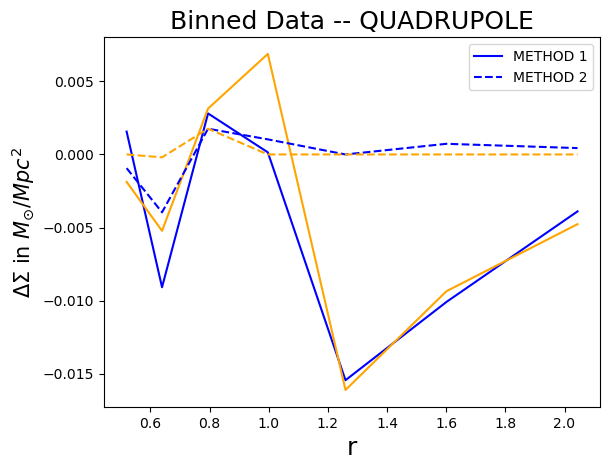

In [18]:
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, 
                                                                                                                      sigma_c=3.77988e+15, method=1)
plt.errorbar(r_quad, ds_quad_4theta, ls='solid', color='blue', label='METHOD 1')
plt.errorbar(r_quad, ds_quad_const, ls='solid', color='orange')

ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, 
                                                                                                                      sigma_c=3.77988e+15, method=2)
plt.errorbar(r_quad, ds_quad_4theta, ls='dashed', color='blue', label='METHOD 2')
plt.errorbar(r_quad, ds_quad_const, ls='dashed', color='orange')
#plt.xlim(0.2,0.5)
plt.xlabel('r', fontsize=18)
plt.title('Binned Data -- QUADRUPOLE',fontsize=18)
plt.ylabel('$\Delta\Sigma$ in $M_{\odot}/Mpc^2$', fontsize=15)
plt.legend()

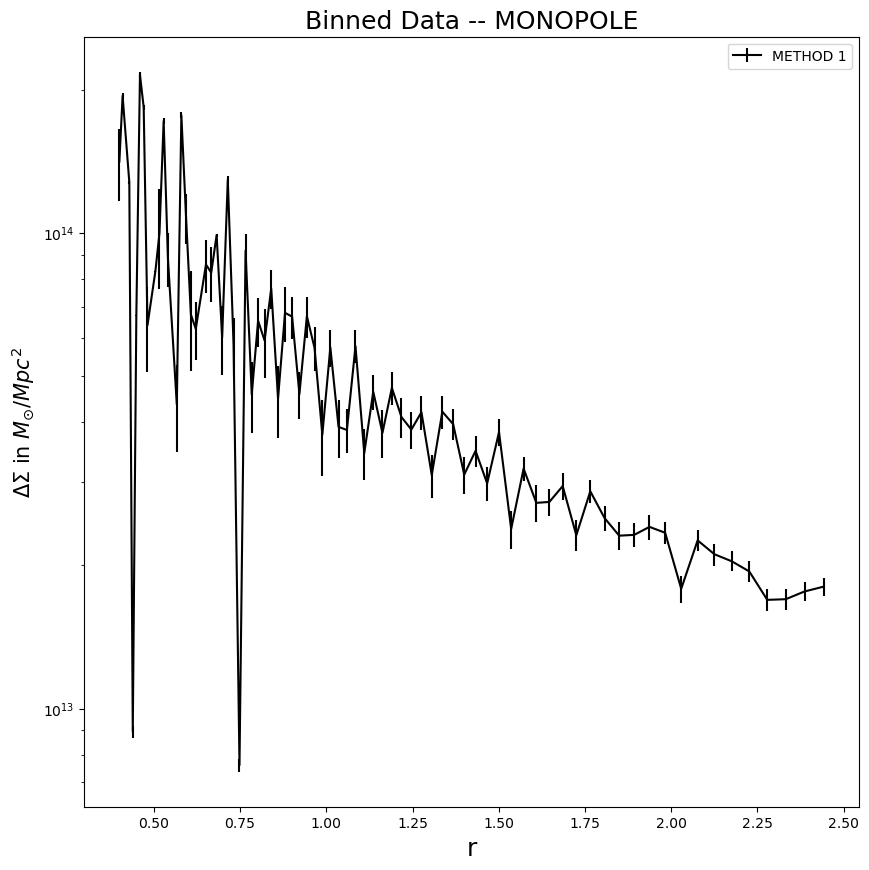

In [127]:
plt.figure(figsize=[10,10])
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, 
                                                                                                                      sigma_c=3.77988e+15, method=1)
plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err, ls='solid', color='black', label='METHOD 1')

ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, 
                                                                                                                      sigma_c=3.77988e+15, method=2)
#plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err, ls='dashed', color='slategray', label='METHOD 2')

#plt.xlim(0.2,0.5)

plt.xlabel('r', fontsize=18)
plt.title('Binned Data -- MONOPOLE',fontsize=18)
plt.ylabel('$\Delta\Sigma$ in $M_{\odot}/Mpc^2$', fontsize=15)
plt.yscale('log')
plt.legend()

In [76]:
#3.77988e+15
print(cosmo.eval_sigma_crit(0.47,0.8))
print(cosmo.eval_da(0.47) * np.pi/180.0 * 1/3600)

3783554794899798.5
0.005885059939355488


In [45]:
print(10**14.3)

199526231496888.28


In [ ]:
q_true=0.5
dir_loc_mcmc = "Elliptical_lenses_data/catalog_horizontal_rescale_q"+str(q_true)+"/"
f=dir_loc_mcmc + "MCMC"

gamma1 = np.load(dir_loc_mcmc+"gamma1.npy").flatten()
gamma2 = np.load(dir_loc_mcmc+"gamma2.npy").flatten()

x_arcsec = np.load(dir_loc_mcmc+"x_arcsec.npy").flatten()
y_arcsec = np.load(dir_loc_mcmc+"y_arcsec.npy").flatten()


#MCMC parameters:
params_key=["M200c","c200c","e"]#,r"$\theta_{e}$ in degrees"]
ndim = len(params_key)
nwalkers = ndim*2+4
nsteps = 10000
nburns = 4000
np.random.seed(0)

limits=[[1.0E12,5.0E14],  # mdelta
       [0.0,20.0],     # cdelta
       [0.0001,0.99]]   # e
       #[0.0, 45.0]]    # theta_e #in degrees
z_cl=0.47
z_gal=0.8
#q_true=0.6 #default = 2/3 for the files in the same directory as this notebook
ell_true= 1*(1-q_true**2)/(1+q_true**2)
#ell_true= 1*(1-q_true)/(1+q_true)
theta_e_true = 0.0
true_value=[2.0E14, 3.89055, ell_true]#,theta_e_true]

'''
Axis ratio q:  0.6666666666666667
c:  3.890554441834905
r200_Mpc: 1.026773208537997
ARCSEC_TO_MPC:  0.00588784182755241
BOX_WIDTH_ARCSEC*ARCSEC_TO_MPC:  5.88784182755241
SIGMA_C=3.77988e+15
arcsec_per_pix:  10.0
'''
# PREP DATA:
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, 
                                                                                                                      y_arcsec, z_cl=0.47, 
                                                                                                                      sigma_c=3.77988e+15, 
                                                                                                                      method=1)


# CALL EMCEE
post, mean, err_plus, err_minus = emcee_wrapper(gamma1, gamma2, x_arcsec, y_arcsec,z_cl=0.47,
                                                params_key=params_key,limits=limits,true_value=true_value, ndim=ndim,nwalkers=nwalkers,
                                                nsteps=nsteps, nburn=nburns, filename=f)

Starting guesses for  10  chains:
[[2.74857938e+14 1.58345008e+01 9.68834297e-01]
 [3.57879494e+14 1.05778984e+01 7.91187063e-01]
 [3.01778925e+14 1.13608912e+01 4.56918421e-01]
 [2.72896708e+14 1.85119328e+01 7.72745832e-01]
 [2.12403745e+14 1.42072116e+00 1.17179854e-01]
 [3.23301162e+14 1.74258599e+00 6.33557819e-01]
 [2.19356018e+14 4.04367949e-01 1.42005419e-01]
 [4.45994727e+14 1.66523969e+01 9.35227761e-01]
 [4.81867717e+14 1.55631350e+01 5.16677654e-01]
 [1.92337318e+14 1.74002430e+01 4.10573854e-01]]


 27%|██▋       | 2728/10000 [02:16<05:43, 21.18it/s]

In [84]:
rho_c=cosmo_astropy.critical_density(0.47).to('M_sun/Mpc**3')
R200c=1.026773208537997
print('Rho_c:',rho_c)
print('R200c',R200c)
print('M200c:',4/3*np.pi*R200c**3*200*rho_c)

Rho_c: 220540221400.42233 solMass / Mpc3
R200c 1.026773208537997
M200c: 199999999999999.97 solMass / Mpc3


In [43]:
ell_true= 1*(1-q_true**2)/(1+q_true**2)
print(ell_true)
bias = np.abs((ell_true -  mean[2]))/ell_true*100
print("Bias in ell:", bias)

0.6
Bias in ell: 1.3468952539690826


In [35]:
ell_true= 1*(1-q_true)/(1+q_true)
print(ell_true)

0.3333333333333333


In [8]:
q_true=0.9 #default = 2/3 for the files in the same directory as this notebook
ell_true= 1*(1-q_true**2)/(1+q_true**2)
print(ell_true)

0.1049723756906077


ell_fit =  0.22216404817544547
14
[-5.90533343e+12 -4.42001910e+12 -3.25414776e+12 -2.35538449e+12
 -1.67455287e+12 -1.16739142e+12 -7.95566482e+11 -5.27009384e+11
 -3.35719515e+11 -2.01203779e+11 -1.07716386e+11 -4.34330313e+10
  3.45498888e+08  2.99032186e+10]


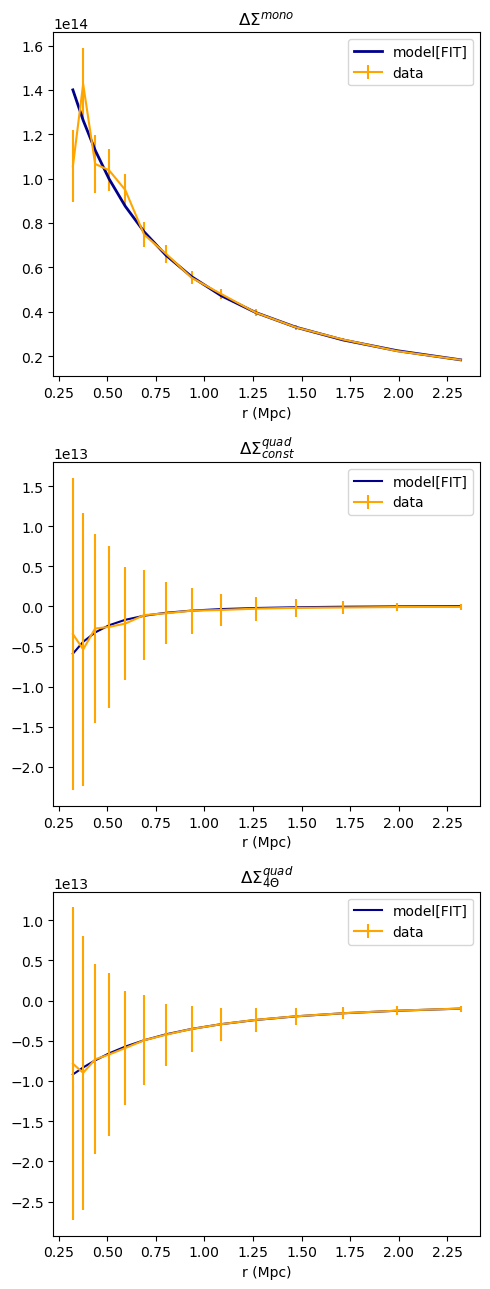

In [26]:
mdelta_fit = mean[0]#2E14#
cdelta_fit = mean[1]#3.89#
ell_fit = mean[2]#ell_true
print("ell_fit = ",ell_fit)
#theta_e_fit = mean[3] #in degrees
cosmo = Cosmology(H0=71.0, Omega_dm0=0.2248, Omega_b0=0.2648 - 0.2248, Omega_k0=0.0)

gamma1 = np.load(dir_loc_mcmc+"gamma1.npy").flatten()
gamma2 = np.load(dir_loc_mcmc+"gamma2.npy").flatten()

x_arcsec = np.load(dir_loc_mcmc+"x_arcsec.npy").flatten()
y_arcsec = np.load(dir_loc_mcmc+"y_arcsec.npy").flatten()

#theta_e_fit = theta_e_fit*np.pi/180.0
#gamma1,gamma2,x_arcsec,y_arcsec = halo_rotation(gamma1,gamma2,x_arcsec,y_arcsec,theta_e_fit)
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15)



plt.figure(figsize=[5,13])
plt.subplot(311)
plt.errorbar(r_mono, ds_mono, yerr=np.abs(ds_mono_err), label='data', color='orange')
print(len(ds_mono))
ds_model = compute_delta_sigma_excess(ell_fit, r_mono, mdelta_fit, cdelta_fit, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=10000, delta_mdef=200)
ds_model_without_e_square = clmm.compute_excess_surface_density(r_mono, mdelta_fit, cdelta_fit, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
plt.plot(r_mono, ds_model, label='model[FIT]', color='darkblue', lw=2)


ds_model = compute_delta_sigma_excess((0.0), r_mono, 2.0E14, 3.89, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=10000, delta_mdef=200)
#plt.plot(r_mono, ds_model, label='model[TRUTH]', color='gray', lw=2)
#plt.plot(r_mono, (ds_mono-ds_model)/ds_model, label='(data - model) / model', color='darkblue', ls='dashed')
#plt.yscale('log')
plt.xlabel('r (Mpc)')
plt.title(r'$\Delta\Sigma^{mono}$')
plt.legend()
#plt.xlim([1.75,2.25])


plt.subplot(312)
ds_model = compute_delta_sigma_const(ell_fit, r_quad, mdelta_fit, cdelta_fit, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=10000, delta_mdef=200)
plt.plot(r_quad, ds_model, label='model[FIT]', color='darkblue')
print(ds_model)
plt.errorbar(r_quad, ds_quad_const,  yerr=ds_quad_const_err, label='data', color='orange')
plt.yscale('linear')
plt.xscale('linear')
plt.title(r'$\Delta\Sigma^{quad}_{const}$')
plt.xlabel('r (Mpc)')
plt.legend()

plt.subplot(313)
ds_model = compute_delta_sigma_4theta(ell_fit, r_quad, mdelta_fit, cdelta_fit, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=10000, delta_mdef=200)
plt.plot(r_quad, ds_model, label='model[FIT]', color='darkblue')

plt.errorbar(r_quad, ds_quad_4theta,  yerr=ds_quad_4theta_err, label='data', color='orange')
plt.yscale('linear')
plt.xscale('linear')
plt.title(r'$\Delta\Sigma^{quad}_{4\Theta}$')
plt.xlabel('r (Mpc)')
plt.legend()
plt.tight_layout()

In [38]:
for p in [5E13,7.38E13, 2E14, 5E14]:
    params=( p, 3.89, 0.1049)
    print(log_likelihood_monopole(ds_mono,ds_mono_err, r_mono,params)+log_likelihood_quadrupole_const(ds_quad_const,ds_quad_const_err, r_quad,params) + log_likelihood_quadrupole_4theta(ds_quad_4theta, ds_quad_4theta_err, r_quad,params))
        

-426913.86121114873
-93004.61581753094
-2079487.5609684037
-14879507.916491512


In [111]:
params =( 2E14, 3.89, 0.1049)
#params=( 7.38E13, 3.89, 0.1049)
mdelta,cdelta,ell = params

ds_data = ds_mono
    
#model:
ds_model = compute_delta_sigma_excess(ell, r_mono, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                         sample_N=1000, delta_mdef=200)#/sigma_c

# Gaussian likelihood:
#sigma = np.full(len(r_mono), ds_model*0.01) 
sigma = ds_mono_err
term1 = -0.5*np.sum(np.log(2*np.pi*(sigma**2)))
chi2 = ((ds_data - ds_model)**2 / (sigma)**2)
term2 = -0.5*np.sum(chi2)
print(term1+term2)
print((ds_data - ds_model)**2)
print((sigma)**2)
print((ds_data - ds_model)**2/(sigma)**2)
print(r_mono)

-275831.3166667561
[1.88327184e+27 6.88331544e+27 4.90832004e+26 9.65222429e+26
 2.85818093e+26 2.20807959e+27 8.52351988e+25 5.52277072e+27
 1.81374810e+25 3.07262700e+27 6.69441213e+26 8.40732122e+26
 3.58278353e+26 4.04905898e+27 4.75888014e+26 9.00256734e+26
 9.42304956e+25 6.29216713e+25 6.09243160e+23 2.66659670e+25
 9.60348573e+26 3.75799734e+26 3.20553105e+24 1.42379498e+26
 6.39459888e+26 7.49610438e+25 6.46454624e+24 4.25158241e+26
 2.78664327e+26 1.29660720e+26 4.14342260e+26 7.70506099e+25
 2.06988920e+25 1.45913811e+26 4.61896936e+25 1.36694159e+26
 2.00535820e+26 1.48209349e+25 1.28369803e+25 9.08396268e+24
 1.94052468e+25 7.00243732e+24 2.36964082e+26 1.10380578e+26
 4.97743992e+25 9.47472564e+25 9.09417164e+24 5.70086524e+25
 4.05516247e+25 8.08775222e+25 9.84763618e+25 2.48277069e+25
 5.66288351e+24 1.25021191e+24 9.71279680e+24 2.98696258e+23
 2.08850185e+22 7.95774262e+23 6.77373291e+24 1.29894725e+24
 3.83496497e+24 9.76705186e+24 3.28647201e+22 9.48214076e+24
 3.50

In [97]:
print(sigma)

[2.44654308e+13 2.58312881e+12 1.03538965e+12 2.44046137e+11
 2.31176932e+10 3.27496505e+12 2.41178674e+12 1.29810388e+13
 2.58461934e+11 2.36663994e+13 2.22298539e+12 1.15061746e+13
 9.05523253e+12 2.48902000e+12 1.30759723e+13 1.59902309e+13
 8.66413775e+12 1.09536828e+13 1.09940388e+13 7.08799995e+11
 1.00246768e+13 2.44332643e+12 8.29327922e+12 2.37388799e+11
 7.80649715e+12 7.78454863e+12 7.75438018e+12 9.80355413e+12
 7.11912561e+12 7.72944727e+12 8.99235486e+12 6.71862041e+12
 5.27699851e+12 6.59061023e+12 6.02951252e+12 6.91083276e+12
 5.15906298e+12 5.40841222e+12 4.05761317e+12 4.63399163e+12
 4.16681844e+12 3.98762045e+12 4.38976964e+12 3.78215224e+12
 4.01585090e+12 3.50904032e+12 3.46422657e+12 3.23424265e+12
 3.29071193e+12 3.01158093e+12 2.71692139e+12 2.56018829e+12
 2.44639741e+12 2.44335126e+12 2.20698974e+12 1.91314933e+12
 2.37908773e+12 1.82544534e+12 1.95842025e+12 1.72248922e+12
 1.55837650e+12 1.55026404e+12 1.55691608e+12 1.37202326e+12
 1.43951911e+12 1.217467

In [79]:
np.array([6,3,2])/np.array([2,2,1])

array([3. , 1.5, 2. ])

<font size=5> MASS BIAS vs q </font>

In [28]:
dir_loc_partial = "Elliptical_lenses_data/catalog_horizontal_rescale_q"

mdelta_fit=[]
mdelta_merr_fit=[]
mdelta_perr_fit=[]

cdelta_fit=[]
cdelta_merr_fit=[]
cdelta_perr_fit=[]

ell_fit=[]
ell_merr_fit=[]
ell_perr_fit=[]

theta_e_fit=[]
theta_e_merr_fit=[]
theta_e_perr_fit=[]
for i,q in enumerate([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]):
    print("Run no.: ",i," q=",q)
    
    dir_loc = dir_loc_partial+str(q)+'/'
    gamma1 = np.load(dir_loc+"gamma1.npy").flatten()
    gamma2 = np.load(dir_loc+"gamma2.npy").flatten()

    x_arcsec = np.load(dir_loc+"x_arcsec.npy").flatten()
    y_arcsec = np.load(dir_loc+"y_arcsec.npy").flatten()


    #MCMC parameters:
    params_key=["M200m","c200m","e",r"$\theta_{e}$ in degrees"]
    ndim = len(params_key)
    nwalkers = ndim*2+4
    nsteps = 6000
    nburns = 3000
    np.random.seed(0)

    limits=[[1.0E12,5.0E14],  # mdelta
           [0.0,20.0],     # cdelta
           [0.0001,0.99],   # e
           [0.0, 45.0]]    # theta_e #in degrees
    z_cl=0.47
    z_gal=0.8
    q_true=0.1 #default = 2/3 for the files in the same directory as this notebook
    ell_true= 1*(1-q_true**2)/(1+q_true**2)
    theta_e_true = 0.0
    true_value=[2.5E14, 3.89055, ell_true,theta_e_true]

    '''
    Axis ratio q:  0.6666666666666667
    c:  3.890554441834905
    r200_Mpc: 1.026773208537997
    ARCSEC_TO_MPC:  0.00588784182755241
    BOX_WIDTH_ARCSEC*ARCSEC_TO_MPC:  5.88784182755241
    SIGMA_C=3.77988e+15
    arcsec_per_pix:  10.0
    '''
    # PREP DATA:
    ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, 
                                                                                                                          z_cl=0.47, sigma_c=3.77988e+15, 
                                                                                                                          method=1)


    # CALL EMCEE
    post, mean, err_plus, err_minus = emcee_wrapper(gamma1, gamma2, x_arcsec, y_arcsec,z_cl=0.47,
                                                    params_key=params_key,limits=limits,true_value=true_value, ndim=ndim,nwalkers=nwalkers,nsteps=nsteps, 
                                                    nburn=nburns, filename=f)
    
    mdelta_fit.append(mean[0])#2.5E14#
    mdelta_merr_fit.append(err_minus[0])
    mdelta_perr_fit.append(err_plus[0])
    
    cdelta_fit.append(mean[1])#3.89#
    cdelta_merr_fit.append(err_minus[1])
    cdelta_perr_fit.append(err_plus[1])
    
    ell_fit.append(mean[2])#ell_true#
    ell_merr_fit.append(err_minus[2])
    ell_perr_fit.append(err_plus[2])
    
    theta_e_fit.append(mean[3]) #in degrees
    theta_e_merr_fit.append(err_minus[3])
    theta_e_perr_fit.append(err_plus[3])

Run no.:  0  q= 0.1
Starting guesses for  12  chains:
[[2.74857938e+14 1.13608912e+01 1.17179854e-01 2.75443075e+01]
 [3.57879494e+14 1.85119328e+01 6.33557819e-01 2.77620299e+01]
 [3.01778925e+14 1.42072116e+00 1.42005419e-01 4.24686635e+01]
 [2.72896708e+14 1.74258599e+00 9.35227761e-01 3.06819135e+01]
 [2.12403745e+14 4.04367949e-01 5.16677654e-01 1.61778555e+01]
 [3.23301162e+14 1.66523969e+01 4.10573854e-01 1.96664379e+01]
 [2.19356018e+14 1.55631350e+01 2.61983600e-01 3.13934038e+01]
 [4.45994727e+14 1.74002430e+01 7.66513929e-01 2.71014622e+00]
 [4.81867717e+14 1.95723668e+01 4.51643214e-01 3.00045022e+01]
 [1.92337318e+14 1.59831713e+01 5.62792766e-01 3.01787041e+01]
 [3.96070794e+14 9.22958725e+00 1.87000235e-02 9.46721525e+00]
 [2.64918565e+14 1.56105835e+01 6.11497379e-01 5.80168339e+00]]


100%|██████████| 6000/6000 [02:38<00:00, 37.75it/s]


Time taken:159.6 seconds
Run no.:  1  q= 0.2
Starting guesses for  12  chains:
[[2.74857938e+14 1.13608912e+01 1.17179854e-01 2.75443075e+01]
 [3.57879494e+14 1.85119328e+01 6.33557819e-01 2.77620299e+01]
 [3.01778925e+14 1.42072116e+00 1.42005419e-01 4.24686635e+01]
 [2.72896708e+14 1.74258599e+00 9.35227761e-01 3.06819135e+01]
 [2.12403745e+14 4.04367949e-01 5.16677654e-01 1.61778555e+01]
 [3.23301162e+14 1.66523969e+01 4.10573854e-01 1.96664379e+01]
 [2.19356018e+14 1.55631350e+01 2.61983600e-01 3.13934038e+01]
 [4.45994727e+14 1.74002430e+01 7.66513929e-01 2.71014622e+00]
 [4.81867717e+14 1.95723668e+01 4.51643214e-01 3.00045022e+01]
 [1.92337318e+14 1.59831713e+01 5.62792766e-01 3.01787041e+01]
 [3.96070794e+14 9.22958725e+00 1.87000235e-02 9.46721525e+00]
 [2.64918565e+14 1.56105835e+01 6.11497379e-01 5.80168339e+00]]


100%|██████████| 6000/6000 [02:51<00:00, 34.94it/s]


Time taken:172.6 seconds
Run no.:  2  q= 0.3
Starting guesses for  12  chains:
[[2.74857938e+14 1.13608912e+01 1.17179854e-01 2.75443075e+01]
 [3.57879494e+14 1.85119328e+01 6.33557819e-01 2.77620299e+01]
 [3.01778925e+14 1.42072116e+00 1.42005419e-01 4.24686635e+01]
 [2.72896708e+14 1.74258599e+00 9.35227761e-01 3.06819135e+01]
 [2.12403745e+14 4.04367949e-01 5.16677654e-01 1.61778555e+01]
 [3.23301162e+14 1.66523969e+01 4.10573854e-01 1.96664379e+01]
 [2.19356018e+14 1.55631350e+01 2.61983600e-01 3.13934038e+01]
 [4.45994727e+14 1.74002430e+01 7.66513929e-01 2.71014622e+00]
 [4.81867717e+14 1.95723668e+01 4.51643214e-01 3.00045022e+01]
 [1.92337318e+14 1.59831713e+01 5.62792766e-01 3.01787041e+01]
 [3.96070794e+14 9.22958725e+00 1.87000235e-02 9.46721525e+00]
 [2.64918565e+14 1.56105835e+01 6.11497379e-01 5.80168339e+00]]


100%|██████████| 6000/6000 [02:38<00:00, 37.80it/s]


Time taken:159.4 seconds
Run no.:  3  q= 0.4
Starting guesses for  12  chains:
[[2.74857938e+14 1.13608912e+01 1.17179854e-01 2.75443075e+01]
 [3.57879494e+14 1.85119328e+01 6.33557819e-01 2.77620299e+01]
 [3.01778925e+14 1.42072116e+00 1.42005419e-01 4.24686635e+01]
 [2.72896708e+14 1.74258599e+00 9.35227761e-01 3.06819135e+01]
 [2.12403745e+14 4.04367949e-01 5.16677654e-01 1.61778555e+01]
 [3.23301162e+14 1.66523969e+01 4.10573854e-01 1.96664379e+01]
 [2.19356018e+14 1.55631350e+01 2.61983600e-01 3.13934038e+01]
 [4.45994727e+14 1.74002430e+01 7.66513929e-01 2.71014622e+00]
 [4.81867717e+14 1.95723668e+01 4.51643214e-01 3.00045022e+01]
 [1.92337318e+14 1.59831713e+01 5.62792766e-01 3.01787041e+01]
 [3.96070794e+14 9.22958725e+00 1.87000235e-02 9.46721525e+00]
 [2.64918565e+14 1.56105835e+01 6.11497379e-01 5.80168339e+00]]


100%|██████████| 6000/6000 [02:34<00:00, 38.77it/s]


Time taken:155.5 seconds
Run no.:  4  q= 0.5
Starting guesses for  12  chains:
[[2.74857938e+14 1.13608912e+01 1.17179854e-01 2.75443075e+01]
 [3.57879494e+14 1.85119328e+01 6.33557819e-01 2.77620299e+01]
 [3.01778925e+14 1.42072116e+00 1.42005419e-01 4.24686635e+01]
 [2.72896708e+14 1.74258599e+00 9.35227761e-01 3.06819135e+01]
 [2.12403745e+14 4.04367949e-01 5.16677654e-01 1.61778555e+01]
 [3.23301162e+14 1.66523969e+01 4.10573854e-01 1.96664379e+01]
 [2.19356018e+14 1.55631350e+01 2.61983600e-01 3.13934038e+01]
 [4.45994727e+14 1.74002430e+01 7.66513929e-01 2.71014622e+00]
 [4.81867717e+14 1.95723668e+01 4.51643214e-01 3.00045022e+01]
 [1.92337318e+14 1.59831713e+01 5.62792766e-01 3.01787041e+01]
 [3.96070794e+14 9.22958725e+00 1.87000235e-02 9.46721525e+00]
 [2.64918565e+14 1.56105835e+01 6.11497379e-01 5.80168339e+00]]


100%|██████████| 6000/6000 [02:38<00:00, 37.96it/s]


Time taken:158.7 seconds
Run no.:  5  q= 0.6
Starting guesses for  12  chains:
[[2.74857938e+14 1.13608912e+01 1.17179854e-01 2.75443075e+01]
 [3.57879494e+14 1.85119328e+01 6.33557819e-01 2.77620299e+01]
 [3.01778925e+14 1.42072116e+00 1.42005419e-01 4.24686635e+01]
 [2.72896708e+14 1.74258599e+00 9.35227761e-01 3.06819135e+01]
 [2.12403745e+14 4.04367949e-01 5.16677654e-01 1.61778555e+01]
 [3.23301162e+14 1.66523969e+01 4.10573854e-01 1.96664379e+01]
 [2.19356018e+14 1.55631350e+01 2.61983600e-01 3.13934038e+01]
 [4.45994727e+14 1.74002430e+01 7.66513929e-01 2.71014622e+00]
 [4.81867717e+14 1.95723668e+01 4.51643214e-01 3.00045022e+01]
 [1.92337318e+14 1.59831713e+01 5.62792766e-01 3.01787041e+01]
 [3.96070794e+14 9.22958725e+00 1.87000235e-02 9.46721525e+00]
 [2.64918565e+14 1.56105835e+01 6.11497379e-01 5.80168339e+00]]


100%|██████████| 6000/6000 [02:33<00:00, 39.16it/s]


Time taken:153.9 seconds
Run no.:  6  q= 0.7
Starting guesses for  12  chains:
[[2.74857938e+14 1.13608912e+01 1.17179854e-01 2.75443075e+01]
 [3.57879494e+14 1.85119328e+01 6.33557819e-01 2.77620299e+01]
 [3.01778925e+14 1.42072116e+00 1.42005419e-01 4.24686635e+01]
 [2.72896708e+14 1.74258599e+00 9.35227761e-01 3.06819135e+01]
 [2.12403745e+14 4.04367949e-01 5.16677654e-01 1.61778555e+01]
 [3.23301162e+14 1.66523969e+01 4.10573854e-01 1.96664379e+01]
 [2.19356018e+14 1.55631350e+01 2.61983600e-01 3.13934038e+01]
 [4.45994727e+14 1.74002430e+01 7.66513929e-01 2.71014622e+00]
 [4.81867717e+14 1.95723668e+01 4.51643214e-01 3.00045022e+01]
 [1.92337318e+14 1.59831713e+01 5.62792766e-01 3.01787041e+01]
 [3.96070794e+14 9.22958725e+00 1.87000235e-02 9.46721525e+00]
 [2.64918565e+14 1.56105835e+01 6.11497379e-01 5.80168339e+00]]


100%|██████████| 6000/6000 [02:38<00:00, 37.86it/s]


Time taken:159.2 seconds
Run no.:  8  q= 0.9
Starting guesses for  12  chains:
[[2.74857938e+14 1.13608912e+01 1.17179854e-01 2.75443075e+01]
 [3.57879494e+14 1.85119328e+01 6.33557819e-01 2.77620299e+01]
 [3.01778925e+14 1.42072116e+00 1.42005419e-01 4.24686635e+01]
 [2.72896708e+14 1.74258599e+00 9.35227761e-01 3.06819135e+01]
 [2.12403745e+14 4.04367949e-01 5.16677654e-01 1.61778555e+01]
 [3.23301162e+14 1.66523969e+01 4.10573854e-01 1.96664379e+01]
 [2.19356018e+14 1.55631350e+01 2.61983600e-01 3.13934038e+01]
 [4.45994727e+14 1.74002430e+01 7.66513929e-01 2.71014622e+00]
 [4.81867717e+14 1.95723668e+01 4.51643214e-01 3.00045022e+01]
 [1.92337318e+14 1.59831713e+01 5.62792766e-01 3.01787041e+01]
 [3.96070794e+14 9.22958725e+00 1.87000235e-02 9.46721525e+00]
 [2.64918565e+14 1.56105835e+01 6.11497379e-01 5.80168339e+00]]


100%|██████████| 6000/6000 [02:36<00:00, 38.23it/s]


Time taken:157.7 seconds
Run no.:  9  q= 1.0
Starting guesses for  12  chains:
[[2.74857938e+14 1.13608912e+01 1.17179854e-01 2.75443075e+01]
 [3.57879494e+14 1.85119328e+01 6.33557819e-01 2.77620299e+01]
 [3.01778925e+14 1.42072116e+00 1.42005419e-01 4.24686635e+01]
 [2.72896708e+14 1.74258599e+00 9.35227761e-01 3.06819135e+01]
 [2.12403745e+14 4.04367949e-01 5.16677654e-01 1.61778555e+01]
 [3.23301162e+14 1.66523969e+01 4.10573854e-01 1.96664379e+01]
 [2.19356018e+14 1.55631350e+01 2.61983600e-01 3.13934038e+01]
 [4.45994727e+14 1.74002430e+01 7.66513929e-01 2.71014622e+00]
 [4.81867717e+14 1.95723668e+01 4.51643214e-01 3.00045022e+01]
 [1.92337318e+14 1.59831713e+01 5.62792766e-01 3.01787041e+01]
 [3.96070794e+14 9.22958725e+00 1.87000235e-02 9.46721525e+00]
 [2.64918565e+14 1.56105835e+01 6.11497379e-01 5.80168339e+00]]


 23%|██▎       | 1380/6000 [00:34<01:57, 39.30it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Text(0, 0.5, 'C200m')

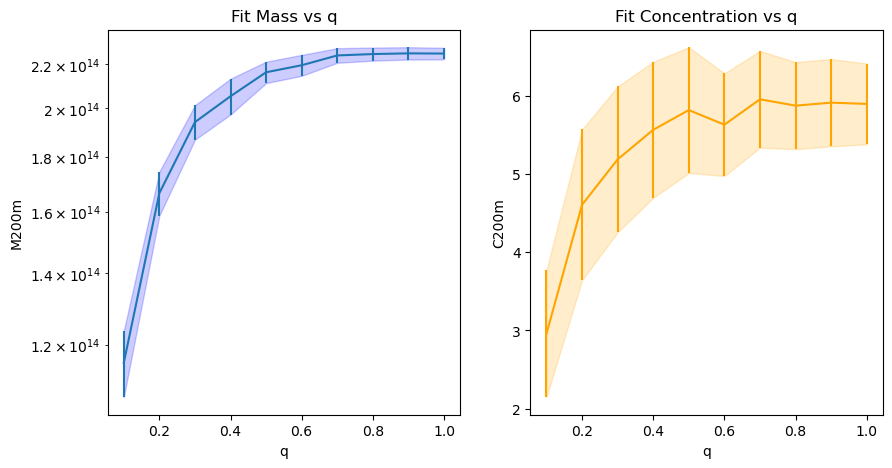

In [29]:
q_arr = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.errorbar(q_arr, mdelta_fit, yerr=mdelta_perr_fit)
plt.fill_between(q_arr, np.array(mdelta_fit)+np.array(mdelta_perr_fit), np.array(mdelta_fit)-np.array(mdelta_perr_fit), color='blue', alpha=0.2)
plt.title('Fit Mass vs q')
plt.xlabel('q')
plt.ylabel('M200m')
plt.yscale('log')

plt.subplot(122)
plt.errorbar(q_arr, cdelta_fit, yerr=cdelta_perr_fit, color='orange')
plt.fill_between(q_arr, np.array(cdelta_fit)+np.array(cdelta_perr_fit), np.array(cdelta_fit)-np.array(cdelta_perr_fit), color='orange', alpha=0.2)
plt.title('Fit Concentration vs q')
plt.xlabel('q')
plt.ylabel('C200m')


<font size=6> Plotting Shears and their ARBITRARY ROTATION: </font>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dir_loc_arr = ["Elliptical_lenses_data/axis_ratio_9_10/","Elliptical_lenses_data/axis_ratio_1/","Elliptical_lenses_data/horizontal_rescale/", "transform"]
n=len(dir_loc_arr)
size=5#int(5/(n-2))
plt.figure(figsize=[n*size,size])
for i,dir_loc in enumerate(dir_loc_arr):
    if dir_loc == "transform":
        plt.subplot(int(10*n)+100+i+1)
        
        theta_e = np.pi/4-np.pi/16 # in radians
        gamma1,gamma2,x_arcsec,y_arcsec = halo_rotation(gamma1,gamma2,x_arcsec,y_arcsec,theta_e)
        q = plt.quiver(x_arcsec, y_arcsec, gamma1, gamma2, headwidth=0)
        plt.xlim([-100,100])
        plt.ylim([-100,100])
        plt.title("Horizontal_rescale + \n theta_e = "+str(theta_e*180.0/np.pi))
    
    else: 
        
        plt.subplot(int(10*n)+100+i+1)
        gamma1 = np.load(dir_loc+"gamma1.npy").flatten()
        gamma2 = np.load(dir_loc+"gamma2.npy").flatten()

        x_arcsec = np.load(dir_loc+"x_arcsec.npy").flatten()
        y_arcsec = np.load(dir_loc+"y_arcsec.npy").flatten()



        X = np.arange(-10, 10, 1)
        Y = np.arange(-10, 10, 1)
        U, V = np.meshgrid(X, Y)

        #plt.figure(figsize=[7,7])
        #fig, ax = plt.subplots()

        q = plt.quiver(x_arcsec, y_arcsec, gamma1, gamma2, headwidth=0)
        #ax.quiverkey(q, X=0.3, Y=1.1, U=10,
        #             label='Quiver key, length = 10', labelpos='E')


        plt.xlim([-100,100])
        plt.ylim([-100,100])
        plt.title(dir_loc)
#plt.show()

<font size=6> TESTING LIKELIHOODS -- [BEWARE] </font>

[1.0e+13 2.0e+13 3.0e+13 4.0e+13 5.0e+13 6.0e+13 7.0e+13 8.0e+13 9.0e+13
 1.0e+14 1.1e+14 1.2e+14 1.3e+14 1.4e+14 1.5e+14 1.6e+14 1.7e+14 1.8e+14
 1.9e+14 2.0e+14 2.1e+14 2.2e+14 2.3e+14 2.4e+14 2.5e+14 2.6e+14 2.7e+14
 2.8e+14 2.9e+14 3.0e+14 3.1e+14 3.2e+14 3.3e+14 3.4e+14 3.5e+14 3.6e+14
 3.7e+14 3.8e+14 3.9e+14 4.0e+14 4.1e+14 4.2e+14 4.3e+14 4.4e+14 4.5e+14
 4.6e+14 4.7e+14 4.8e+14 4.9e+14 5.0e+14 5.1e+14 5.2e+14 5.3e+14 5.4e+14
 5.5e+14 5.6e+14 5.7e+14 5.8e+14 5.9e+14 6.0e+14 6.1e+14 6.2e+14 6.3e+14
 6.4e+14 6.5e+14 6.6e+14 6.7e+14 6.8e+14 6.9e+14 7.0e+14 7.1e+14 7.2e+14
 7.3e+14 7.4e+14 7.5e+14 7.6e+14 7.7e+14 7.8e+14 7.9e+14 8.0e+14 8.1e+14
 8.2e+14 8.3e+14 8.4e+14 8.5e+14 8.6e+14 8.7e+14 8.8e+14 8.9e+14 9.0e+14
 9.1e+14 9.2e+14 9.3e+14 9.4e+14 9.5e+14 9.6e+14 9.7e+14 9.8e+14 9.9e+14
 1.0e+15]
[-58494.627138733995, -50157.95457360413, -43172.4036943896, -37128.13730970341, -31822.593260328373, -27132.371152183798, -22973.471564914194, -19284.574623792498, -16018.700205673753, -

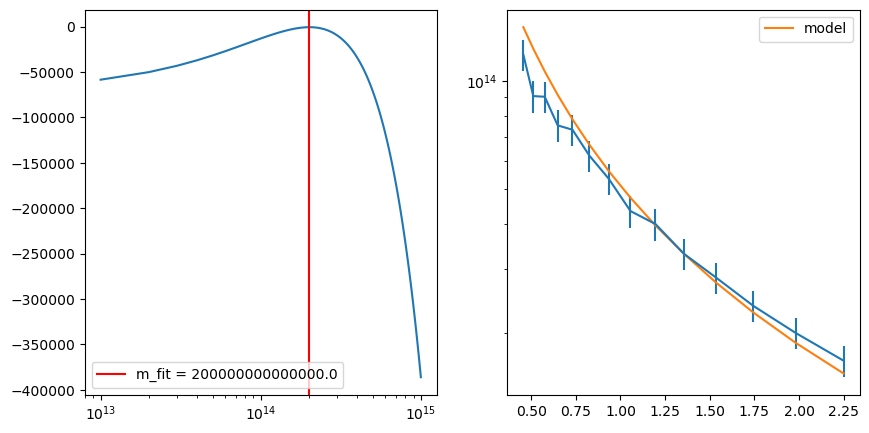

In [14]:
mdelta=1.34E13
cdelta = 12
ell = 0.0
l=[]

def log_likelihood_monopole_temp(params, ds_mono,ds_mono_err, r_mono):
    sigma_c = 3.77988e+15
    z_cl=0.47
    z_gal=1.0
    mdelta = params  # km/s
    ell=0.0
    cdelta=12.0
    ds_data = ds_mono
    
    #model:
    func = np.vectorize(compute_delta_sigma_excess)
    ds_model = func(ell, r_mono, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)#/sigma_c
    
    # Gaussian likelihood:
    #sigma = np.full(len(r_mono), ds_model*0.01) 
    sigma = ds_mono*0.01#np.abs(ds_mono_err)
    term1 = -0.5*np.sum(np.log(2*np.pi*(sigma**2)))
    chi2 = ((ds_data - ds_model)**2 / (sigma)**2)
    term2 = -0.5*np.sum(chi2)

    return (term2)
m_arr=np.linspace(10**13,10**15,10**2)
for mdelta in m_arr:
    params=mdelta
    l.append(log_likelihood_monopole_temp(params, ds_mono,ds_mono_err, r_mono))
    
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(m_arr,l)
plt.axvline(m_arr[np.argmax(l)], color='red', label='m_fit = '+str(m_arr[np.argmax(l)]))
plt.xscale('log')
plt.legend()

plt.subplot(122)
plt.errorbar(r_mono, ds_mono, yerr=np.abs(ds_mono*0.1))

mdelta=m_arr[np.argmax(l)]
print(m_arr)
cdelta = 12
ell = 0.0

ds_model = compute_delta_sigma_excess(ell, r_mono, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)
plt.plot(r_mono, ds_model, label='model')
plt.yscale('log')
plt.legend()

print(l)
mdelta=1E15
ds_model = compute_delta_sigma_excess(ell, r_mono, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)
print(ds_model, ds_mono)
print(-0.5*(ds_model - ds_mono)**2)

In [161]:
from scipy.optimize import minimize
res = minimize(log_likelihood_monopole_temp, [14.0E14], args=(ds_mono,ds_mono_err, r_mono), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), 
                        tol=None, callback=None, options=None)

print(res)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1751919.354392614
        x: [ 1.400e+15]
      nit: 0
      jac: [-2.129e-09]
 hess_inv: [[1]]
     nfev: 2
     njev: 1


In [185]:
mdelta=[0.0001]
r=[0.1,1.0]
func = np.vectorize(clmm.compute_excess_surface_density)
func(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)

array([0.02464215, 0.00029106])

<font size=6> GENERATE NFW MOCK CATALOGS </font>

In [7]:
import numpy as np
from astropy.cosmology import FlatwCDM
cosmo = FlatwCDM(H0=70, Om0=0.3, w0=-1.0)
import astropy.constants as const
import astropy.units as units
from scipy import integrate, signal
from astropy.io import fits

def sigma_nfw(r,R_cluster,c,M_cluster,z_cluster,cosmo_t):
    rs_cluster = R_cluster/c
    x=r/rs_cluster
    
    rs_cluster_t=rs_cluster*(cosmo_t.angular_diameter_distance(z_cluster)/cosmo.angular_diameter_distance(z_cluster)).value
    k=M_cluster/(4.0*np.pi*rs_cluster_t**2*(np.log(1.0+c)-c/(1.0+c))) # k = rho_c*delta_c*r_s in M_solar/Mpc^2
    if x < 1:
        value=2.0*k*(1.0-2.0*np.arctanh(np.sqrt((1.0-x)/(1.0+x)))/np.sqrt(1.0-x**2))/(x**2-1.0)
    if x == 1:
        value=2.0*k/3.0
    if x > 1:
        value=2.0*k*(1.0-2.0*np.arctan(np.sqrt((x-1)/(1+x)))/np.sqrt(x**2-1.0))/(x**2-1.0)
    
    #value is in M_solar / MPc^2 units
    return value

def sigma_c(z,z_cluster,cosmo_t):
    value=(const.c**2*cosmo_t.angular_diameter_distance(z)/cosmo_t.angular_diameter_distance(z_cluster)/cosmo_t.angular_diameter_distance_z1z2(z_cluster,z)/(4*np.pi*const.G)).to('Msun/(Mpc**2)').value
    #value in M_solar/Mpc**2 units
    return value

def kappa_nfw(r,R_cluster,c,M_cluster,z_cluster,cosmo_t):
    return sigma_nfw(r,R_cluster,c,M_cluster,z_cluster,cosmo_t)/sigma_c(z,z_cluster,cosmo_t)

def g_lt(r,rs_cluster): # arbitrary functions for ease of calculation. Not to be confused with red. shear g
    x=r/rs_cluster
    term1=8.0*np.arctanh(np.sqrt((1.0-x)/(1.0+x)))/(x**2*np.sqrt(1.0-x**2))
    term2=4.0*np.log(x/2.0)/x**2
    term3=2.0/(x**2-1.0)
    term4=4.0*np.arctanh(np.sqrt((1.0-x)/(1.0+x)))/((x**2-1.0)*np.sqrt(1.0-x**2))
    
    return term1+term2-term3+term4

def g_gt(r,rs_cluster):
    x=r/rs_cluster
    term1=8.0*np.arctan(np.sqrt((x-1.0)/(1.0+x)))/(x**2*np.sqrt(x**2-1.0))
    term2=4.0*np.log(x/2.0)/x**2
    term3=2.0/(x**2-1.0)
    term4=4.0*np.arctan(np.sqrt((x-1.0)/(1.0+x)))/((x**2-1.0)**1.5)
    
    return term1+term2-term3+term4

def gamma_nfw(r,z,R_cluster,c,M_cluster,z_cluster,cosmo_t):
    rs_cluster = R_cluster/c
    x=r/rs_cluster
    rs_cluster_t=rs_cluster*(cosmo_t.angular_diameter_distance(z_cluster)/cosmo.angular_diameter_distance(z_cluster)).value
    k=M_cluster/(4.0*np.pi*rs_cluster_t**2*(np.log(1.0+c)-c/(1.0+c))) # k = rho_c*delta_c*r_s in M_solar/Mpc^2 units
    if  x < 1:
        value=k*g_lt(r,rs_cluster)/sigma_c(z,z_cluster,cosmo_t)
    if x == 1:
        value=k*(10.0/3.0+4.0*np.log(0.5))/sigma_c(z,z_cluster,cosmo_t)
    if x > 1:
        value=k*g_gt(r,rs_cluster)/sigma_c(z,z_cluster,cosmo_t)
    
    return value

def gamma_inf(r,z,R_cluster,c,M_cluster,z_cluster,cosmo_t):
    rs_cluster = R_cluster/c
    x=r/rs_cluster
    rs_cluster_t=rs_cluster*(cosmo_t.angular_diameter_distance(z_cluster)/cosmo.angular_diameter_distance(z_cluster)).value
    k=M_cluster/(4.0*np.pi*rs_cluster_t**2*(np.log(1.0+c)-c/(1.0+c))) # k = rho_c*delta_c*r_s in M_solar/Mpc^2 units
    if  x < 1:
        value=k*g_lt(r,rs_cluster)
    if x == 1:
        value=k*(10.0/3.0+4.0*np.log(0.5))
    if x > 1:
        value=k*g_gt(r,rs_cluster)
    
    return value

def g_nfw(r,z,R_cluster,c,M_cluster,z_cluster,cosmo_t): # Function for reduced shear from gamma and kappa
    val=[]
    for i in range(len(r)):
        #val.append(gamma_nfw(r[i],z[i],rs_cluster,M_cluster,z_cluster,cosmo_t)/(1-kappa_nfw(r[i],z[i],rs_cluster,M_cluster,z_cluster,cosmo_t)))
        val.append(gamma_nfw(r[i],z[i],R_cluster,c,M_cluster,z_cluster,cosmo_t))
    return np.array(val)

In [8]:
#defining the Probability distribution function for galaxy redshift, 0<=z<=2.5
def gal_z_pdf(z):
    a_pdf=0.612
    b_pdf=8.125
    c_pdf=0.620
    A_pdf=1.555
    
    return A_pdf*(z**a_pdf+z**(a_pdf*b_pdf))/(z**b_pdf+c_pdf)

def draw_redshift_of_galaxy(N=10**3, z1z2_delta=0.3, z_min=0, z_max=2.5):
    
    print("Passed arguments: N=",N," z1z2_delta=",z1z2_delta," z_min=",z_min," z_max=",z_max)
    #Discretization of redshift range for CDF calculations:
    N_cdf=1000
    del_z=(z_max-z_min)/N_cdf
    z=np.linspace(z_min+del_z,z_max,N_cdf)

    #Cumulative Distribution function:
    cdf=[]
    z_cdf=[]
    i=0
    for z_i in z:
        zz=np.linspace(z_min,z_i, int(((z_i-z_min)/del_z)*10**2))
        y=gal_z_pdf(zz)
        val=integrate.simps(y, zz)
        cdf.append(val)
        z_cdf.append(z_i+del_z/2)
        i=i+1
    cdf=np.array(cdf/np.max(cdf))
    z_cdf=np.array(z_cdf)

    #redshift drawing:
    z1_drawn=[]
    i=0

    while i < N :
        cdf1_r=random.uniform(min(cdf),max(cdf))
        k=np.max(np.where(cdf < cdf1_r))
        l=np.min(np.where(cdf > cdf1_r))
        
        ## linear interpol. between two points on CDF:
        z1_r=(cdf1_r-cdf[k])*(z_cdf[l]-z_cdf[k])/(cdf[l]-cdf[k])+z_cdf[k]
        if z1_r > z_cluster and z1_r < z_max-z1z2_delta:
            z1_drawn.append(z1_r)
            i=i+1
                
    return z1_drawn

def draw_redshift_pairs(N=10**3, z1z2_delta=0.3, z_min=0, z_max=2.5, want_pairs=True):
    
    print("Passed arguments: N=",N," z1z2_delta=",z1z2_delta," z_min=",z_min," z_max=",z_max)
    print("Want_pairs is set to: ",want_pairs)
    #Discretization of redshift range for CDF calculations:
    N_cdf=1000
    del_z=(z_max-z_min)/N_cdf
    z=np.linspace(z_min+del_z,z_max,N_cdf)

    #Cumulative Distribution function:
    cdf=[]
    z_cdf=[]
    i=0
    for z_i in z:
        zz=np.linspace(z_min,z_i, int(((z_i-z_min)/del_z)*10**2))
        y=gal_z_pdf(zz)
        val=integrate.simps(y, zz)
        cdf.append(val)
        z_cdf.append(z_i+del_z/2)
        i=i+1
    cdf=np.array(cdf/np.max(cdf))
    z_cdf=np.array(z_cdf)

    #redshift drawing:
    if want_pairs == True:
        z1_drawn=[]
        z2_drawn=[]
        i=0
        while i < N :
            cdf1_r=random.uniform(min(cdf),max(cdf))
            k=np.max(np.where(cdf < cdf1_r))
            l=np.min(np.where(cdf > cdf1_r))
            find_z2=True
            ## linear interpol. between two points on CDF:
            z1_r=(cdf1_r-cdf[k])*(z_cdf[l]-z_cdf[k])/(cdf[l]-cdf[k])+z_cdf[k]  
            if z1_r > z_cluster and z1_r < z_max-z1z2_delta:
                while i < N and find_z2==True:
                    cdf2_r=random.uniform(min(cdf),max(cdf))
                    k=np.max(np.where(cdf < cdf2_r))
                    l=np.min(np.where(cdf > cdf2_r))
                    ## linear interpol. between two points on CDF
                    z2_r=(cdf2_r-cdf[k])*(z_cdf[l]-z_cdf[k])/(cdf[l]-cdf[k])+z_cdf[k]  
                    if z2_r > z1_r+0.3 and z2_r < z_max:
                        z1_drawn.append(z1_r)
                        z2_drawn.append(z2_r)
                        find_z2=False
                        i=i+1
    if want_pairs == False:
        ### For the case when we want to generate N*2 galaxies not behind each other using the same code
        ### See the daw_position_pairs function definition for more details.
        z1_drawn=[]
        z2_drawn=[]
        i=0
        while i < N :
            cdf1_r=random.uniform(min(cdf),max(cdf))
            k=np.max(np.where(cdf < cdf1_r))
            l=np.min(np.where(cdf > cdf1_r))
            ## linear interpol. between two points on CDF:
            z1_r=(cdf1_r-cdf[k])*(z_cdf[l]-z_cdf[k])/(cdf[l]-cdf[k])+z_cdf[k]  
            if z1_r > z_cluster and z1_r < z_max-z1z2_delta: 
                z1_drawn.append(z1_r)
                i=i+1
        i=0
        while i < N :
            cdf2_r=random.uniform(min(cdf),max(cdf))
            k=np.max(np.where(cdf < cdf1_r))
            l=np.min(np.where(cdf > cdf1_r))
            ## linear interpol. between two points on CDF:
            z2_r=(cdf2_r-cdf[k])*(z_cdf[l]-z_cdf[k])/(cdf[l]-cdf[k])+z_cdf[k]  
            if z2_r > z_cluster and z1_r < z_max-z1z2_delta: 
                z2_drawn.append(z2_r)
                i=i+1

    z1_gal=np.array(z1_drawn)
    z2_gal=np.array(z2_drawn)
    print("Generated Redshift Pairs successfully ...")
    return z1_gal, z2_gal

def draw_position_pairs(N=10**3, r_min=0.5, r_max=5.0, want_pairs=True):
    #def draw_position_pairs(*args, **kwargs):
    #Draw (x,y) Mpc for each pair of galaxies
    # Small box size: [-r_min/np.sqrt(2),r_min/np.sqrt(2)] 
    # Large box size: [-r_max,r_max]
    
    print("Passed arguments: N=",N," r_min=",r_min," r_max=",r_max)
    print("Want_pairs is set to: ",want_pairs)
    x1=np.array([])
    y1=np.array([])
    while (len(x1) < N):
        x_r,y_r = np.random.uniform(r_min/np.sqrt(2),r_max,size=(2,N))*np.random.choice([-1,1], (2,N))
        ind = np.where((np.sqrt(x_r**2+y_r**2) > r_min) & (np.sqrt(x_r**2+y_r**2) < r_max))[0]
        x1 = np.append(x1,x_r[ind])
        y1 = np.append(y1,y_r[ind])
    x1=x1[:N]
    y1=y1[:N]
    
    ## Placing second galaxy EXACTLY behind the first one:
    x2=x1
    y2=y1
    if want_pairs == False:
        ### When we want to generate just N*2 galaxies instead of N galaxy pairs. All that
        ### is needed, is to generate a random position of the second galaxy. The "paired" galaxy are 
        ### completely disjoint as redshifts will also be drawn independently.
        
        x2=np.array([])
        y2=np.array([])
        while (len(x2) < N):
            x_r,y_r = np.random.uniform(r_min/np.sqrt(2),r_max,size=(2,N))*np.random.choice([-1,1], (2,N))
            ind = np.where((np.sqrt(x_r**2+y_r**2) > r_min) & (np.sqrt(x_r**2+y_r**2) < r_max))[0]
            x2 = np.append(x2,x_r[ind])
            y2 = np.append(y2,y_r[ind])
        x2=x2[:N]
        y2=y2[:N]
        
    print("Generated Position Pairs successfully ...")
    return x1,y1,x2,y2

def draw_shape_pairs(N=10**3, g_sigma=0.24):
    #def draw_shape_pairs(*args, **kwargs):
    ## e1_1, e1_2: refers to galaxy 1 (e1,e2)
    ## e2_1, e2_2: refers to galaxy 2 (e1,e2)
    
    print("Passed arguments: N=",N," g_sigma=",g_sigma)
    e1_1_arr=np.array([])
    e1_2_arr=np.array([])
    e2_1_arr=np.array([])
    e2_2_arr=np.array([])
    i=0
    while i < N:
        e1_1,e1_2,e2_1,e2_2=np.random.normal(loc=0.0,scale=g_sigma, size=4)
        if e1_1 > -1 and e1_1 < 1 and e1_2 > -1 and e1_2 < 1 and e2_1 > -1 and e2_1 < 1 and e2_2 > -1 and e2_2<1:
            e1_1_arr = np.append(e1_1_arr,e1_1)
            e1_2_arr = np.append(e1_2_arr,e1_2)
            e2_1_arr = np.append(e2_1_arr,e2_1)
            e2_2_arr = np.append(e2_2_arr,e2_2)
            i=i+1
    print("Generated",N," Intrinsic shapes successfully ...")
    return e1_1_arr,e1_2_arr,e2_1_arr,e2_2_arr

#def generate_shear_catalog(N=10**3, z1z2_delta=0.3, z_min=0, z_max=2.5, 
#                            r_min=0.5, r_max=5.0, g_sigma=0.24, *args, **kwargs):
def generate_shear_catalog(R_cluster,c,M_cluster, z_cluster, fid_cosmology, file=None, want_pairs=True,
                           *args, **kwargs): 
    
    print("Passed arguments: sigma_v_cluster=",sigma_v_cluster," z_cluster=",z_cluster,
          "fid_cosmology=",fid_cosmology)
    #Draw redshifts:
    z1,z2 = draw_redshift_pairs(N, z1z2_delta, z_min, z_max, want_pairs=want_pairs)
    x1,y1,x2,y2 = draw_position_pairs(N, r_min, r_max, want_pairs=want_pairs)
    e1_1, e1_2, e2_1, e2_2 = draw_shape_pairs(N, g_sigma)
    
    r1 = np.sqrt(x1**2+y1**2)
    r2 = np.sqrt(x2**2+y2**2)
    phi_1 = np.arctan2(x1,y1) # in radians
    phi_2 = np.arctan2(x2,y2) # in radians
    
    #Draw tangential reduced shears:
    #r,z,rs_cluster,M_cluster,z_cluster,cosmo_t
    gt_1 = g_nfw(r1,z1,R_cluster,c,M_cluster,z_cluster, fid_cosmology)
    gt_2 = g_nfw(r2,z2,R_cluster,c,M_cluster,z_cluster, fid_cosmology)
    
    ## γt = −[γ1 cos(2ϕ) + γ2 sin(2ϕ)],
    ## SOURCE: Taylor 2007, "Probing dark energy with the shear-ratio geometric test"
    
    et_int_1 = -1*(e1_1*np.cos(2*phi_1) +e1_2*np.sin(2*phi_1))
    et_int_2 = -1*(e2_1*np.cos(2*phi_2) +e2_2*np.sin(2*phi_2))
    et_1 = gt_1 #+ et_int_1
    et_2 = gt_2 #+ et_int_2
    
    if file == None:
        dictionary = {
            "z1":z1,
            "z2":z2,
            "r1":r1,
            "r2":r2,
            "et_1":et_1,
            "et_2":et_2,            
        }
        return dictionary
    
    ## Saving the catalog to file
    if file != None:
        hdu = fits.BinTableHDU.from_columns(
         [fits.Column(name='No.', format='I', array=np.arange(N)+1),
          fits.Column(name='z1', format='E', array=np.round(z1,3)),
          fits.Column(name='z2', format='E', array=np.round(z2,3)),
          fits.Column(name='x1', format='E', array=np.round(x1,3)),
          fits.Column(name='y1', format='E', array=np.round(y1,3)),
          fits.Column(name='x2', format='E', array=np.round(x2,3)),
          fits.Column(name='y2', format='E', array=np.round(y2,3)),
          fits.Column(name='r1', format='E', array=np.round(r1,3)),
          fits.Column(name='r2', format='E', array=np.round(r2,3)),
          fits.Column(name='phi_1', format='E', array=np.round(phi_1,3)),
          fits.Column(name='phi_2', format='E', array=np.round(phi_2,3)),
          fits.Column(name='e1_1', format='E', array=e1_1),
          fits.Column(name='e1_2', format='E', array=e1_2),
          fits.Column(name='e2_1', format='E', array=e2_1),
          fits.Column(name='e2_2', format='E', array=e2_2),
          fits.Column(name='et_1', format='E', array=et_1),
          fits.Column(name='et_2', format='E', array=et_2),
          fits.Column(name='et_int_1', format='E', array=et_int_1),
          fits.Column(name='et_int_2', format='E', array=et_int_2),
          fits.Column(name='gt_1', format='E', array=gt_1),
          fits.Column(name='gt_2', format='E', array=gt_2)])
        hdu.writeto(file, overwrite=True)
        print('Catalog of shears and redshifts written to %s ' %file)
        

In [9]:
M_cluster = 10**15 # Solar Masses
R_cluster = 1.5 # Mpc
rs_cluster=0.418 # in Mpc
c = R_cluster/rs_cluster
#z_cluster=0.182 ## Default
z_cluster = 0.5

#SOURCE: Taylor 2007, "Probing dark energy with the shear-ratio geometric test"
sigma_v_cluster=np.sqrt((3*const.G*(M_cluster*units.M_sun))/(2*(R_cluster*units.Mpc))).to('km/s').value
print("sigma_v of cluster=", sigma_v_cluster)

#M_cluster=10.671*10**14
w0=-1.0  #fiducial cosmology
r_min=1.0
r_max=3.0
g_sigma=0.0001
z1z2_delta=0.3
z_min=z_cluster+0.05
z_max=2.5
N=5000
want_pairs_choice = False

file_loc = "/global/u2/s/sriniva/Elliptical_lenses_data/Rad_NFW_halos/"
catalog_name = "Galaxy_catalog_"+str(N)+'_sigma_'+str(g_sigma)+"_r_min_"+str(
    np.round(r_min,1))+"_r_max_"+str(np.round(r_max,1))+"_z_cluster_"+str(
    z_cluster)+".fits"

if want_pairs_choice == False:
    misc="Individual_"
else:
    misc=""
file = file_loc + misc + catalog_name
cosmo = FlatwCDM(H0=70, Om0=0.3, w0=-1.0)

generate_shear_catalog(R_cluster,c,M_cluster, z_cluster, cosmo, file, N=N, z1z2_delta=z1z2_delta, z_min=z_min, 
                       z_max=z_max, r_min=r_min, r_max=r_max, g_sigma=g_sigma, 
                       want_pairs=want_pairs_choice)

'''
r=np.linspace(0.6,3.0,9)

for i,r_i in enumerate(r):
    if i == len(r) - 1: break
    r_min = r_i
    r_max = r[i+1]
    N = int(np.ceil(1000*(r_max**2 - r_min**2)/(r[1]**2-r[0]**2)))

    file_loc = "/global/u2/s/sriniva/Shear_ratio_project_new/Shear_catalogs/SIS/"
    file=file_loc+"Galaxy_catalog_"+str(N)+'_sigma_'+str(g_sigma)+"_r_min_"+str(
        np.round(r_min,1))+"_r_max_"+str(np.round(r_max,1))+".fits"

    generate_shear_catalog(sigma_v_cluster, z_cluster, cosmo, file, N=N, z1z2_delta=z1z2_delta, z_min=z_min, 
                           z_max=z_max, r_min=r_min, r_max=r_max, g_sigma=g_sigma)
'''

sigma_v of cluster= 2073.8652969844206
Passed arguments: sigma_v_cluster= 2073.8652969844206  z_cluster= 0.5 fid_cosmology= FlatwCDM(H0=70.0 km / (Mpc s), Om0=0.3, w0=-1.0, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)
Passed arguments: N= 5000  z1z2_delta= 0.3  z_min= 0.55  z_max= 2.5
Want_pairs is set to:  False
Generated Redshift Pairs successfully ...
Passed arguments: N= 5000  r_min= 1.0  r_max= 3.0
Want_pairs is set to:  False
Generated Position Pairs successfully ...
Passed arguments: N= 5000  g_sigma= 0.0001
Generated 5000  Intrinsic shapes successfully ...
Catalog of shears and redshifts written to /global/u2/s/sriniva/Elliptical_lenses_data/Rad_NFW_halos/Individual_Galaxy_catalog_5000_sigma_0.0001_r_min_1.0_r_max_3.0_z_cluster_0.5.fits 


'\nr=np.linspace(0.6,3.0,9)\n\nfor i,r_i in enumerate(r):\n    if i == len(r) - 1: break\n    r_min = r_i\n    r_max = r[i+1]\n    N = int(np.ceil(1000*(r_max**2 - r_min**2)/(r[1]**2-r[0]**2)))\n\n    file_loc = "/global/u2/s/sriniva/Shear_ratio_project_new/Shear_catalogs/SIS/"\n    file=file_loc+"Galaxy_catalog_"+str(N)+\'_sigma_\'+str(g_sigma)+"_r_min_"+str(\n        np.round(r_min,1))+"_r_max_"+str(np.round(r_max,1))+".fits"\n\n    generate_shear_catalog(sigma_v_cluster, z_cluster, cosmo, file, N=N, z1z2_delta=z1z2_delta, z_min=z_min, \n                           z_max=z_max, r_min=r_min, r_max=r_max, g_sigma=g_sigma)\n'

Starting guesses for  12  chains:
[[2.74451871e+15 1.13608912e+01 1.17179854e-01 2.75443075e+01]
 [3.57623164e+15 1.85119328e+01 6.33557819e-01 2.77620299e+01]
 [3.01421412e+15 1.42072116e+00 1.42005419e-01 4.24686635e+01]
 [2.72487103e+15 1.74258599e+00 9.35227761e-01 3.06819135e+01]
 [2.11885034e+15 4.04367949e-01 5.16677654e-01 1.61778555e+01]
 [3.22982467e+15 1.66523969e+01 4.10573854e-01 1.96664379e+01]
 [2.18849847e+15 1.55631350e+01 2.61983600e-01 3.13934038e+01]
 [4.45897323e+15 1.74002430e+01 7.66513929e-01 2.71014622e+00]
 [4.81835014e+15 1.95723668e+01 4.51643214e-01 3.00045022e+01]
 [1.91782415e+15 1.59831713e+01 5.62792766e-01 3.01787041e+01]
 [3.95883347e+15 9.22958725e+00 1.87000235e-02 9.46721525e+00]
 [2.64494570e+15 1.56105835e+01 6.11497379e-01 5.80168339e+00]]


  4%|▍         | 262/6000 [00:06<02:14, 42.53it/s]/tmp/ipykernel_2155535/169669499.py:7: RuntimeWarning: invalid value encountered in divide
  return Sigma_crit * (w1*gamma1/np.cos(4*theta) + w2*gamma2/np.sin(4*theta)) / (w1 + w2)
 17%|█▋        | 1027/6000 [00:24<01:55, 43.13it/s]/tmp/ipykernel_2155535/169669499.py:7: RuntimeWarning: invalid value encountered in divide
  return Sigma_crit * (w1*gamma1/np.cos(4*theta) + w2*gamma2/np.sin(4*theta)) / (w1 + w2)
 18%|█▊        | 1107/6000 [00:26<01:55, 42.36it/s]/tmp/ipykernel_2155535/169669499.py:7: RuntimeWarning: invalid value encountered in divide
  return Sigma_crit * (w1*gamma1/np.cos(4*theta) + w2*gamma2/np.sin(4*theta)) / (w1 + w2)
 22%|██▏       | 1307/6000 [00:30<01:47, 43.69it/s]/tmp/ipykernel_2155535/169669499.py:7: RuntimeWarning: invalid value encountered in divide
  return Sigma_crit * (w1*gamma1/np.cos(4*theta) + w2*gamma2/np.sin(4*theta)) / (w1 + w2)
 34%|███▎      | 2022/6000 [00:47<01:31, 43.55it/s]/tmp/ipykernel_2155535

Time taken:140.9 seconds


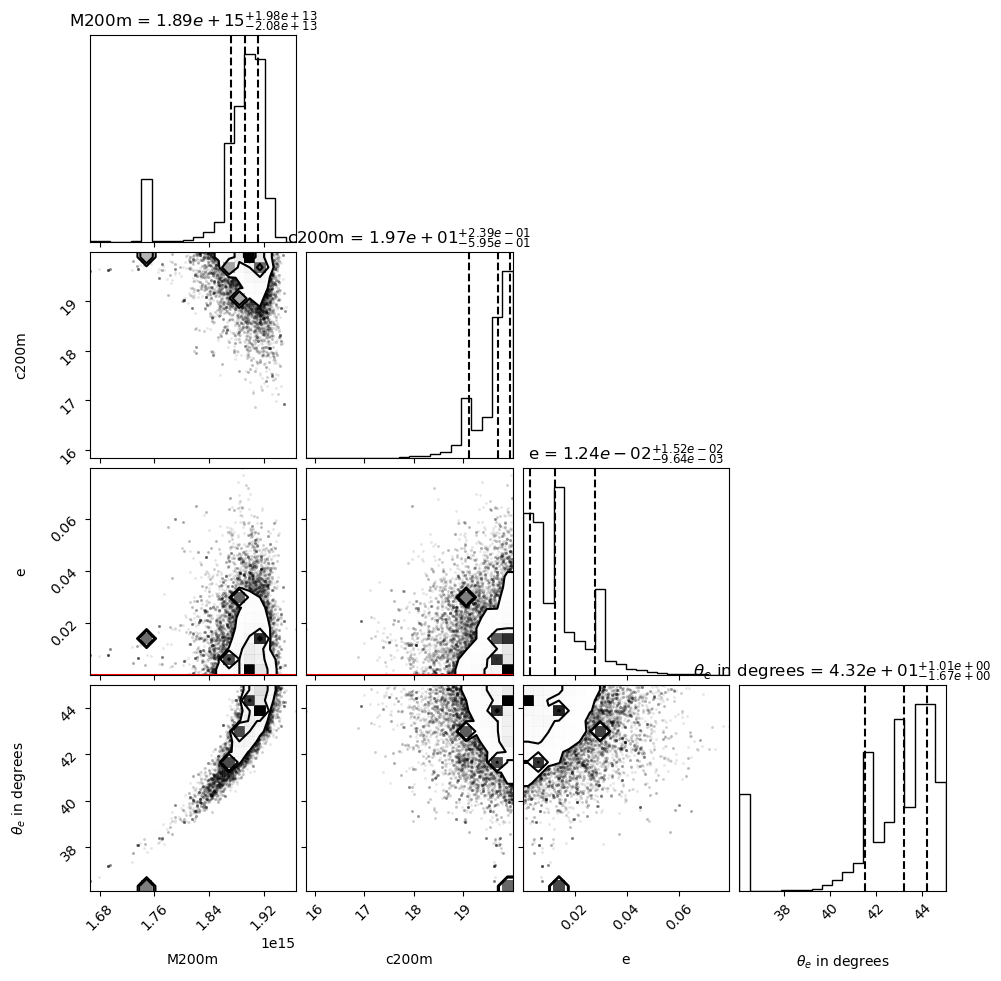

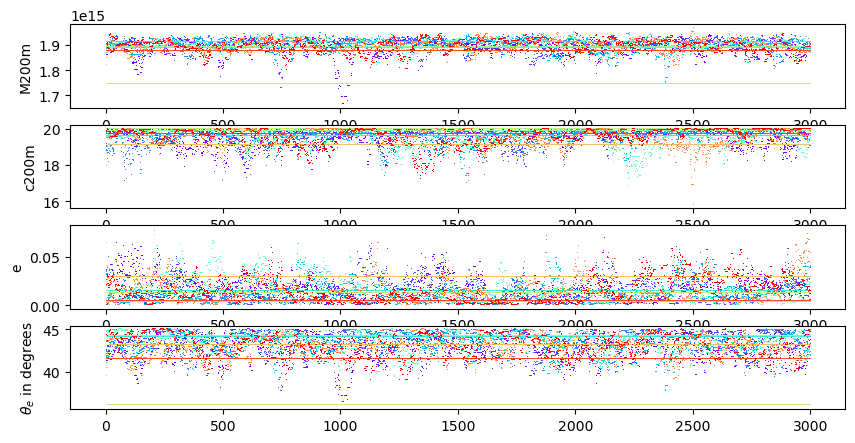

In [79]:
f=None

#cosmo = FlatwCDM(H0=70, Om0=0.3, w0=-1.0)
cosmo = Cosmology(H0=70.0, Omega_dm0=0.3, Omega_b0=0.000, Omega_k0=0.0)

## DATA:
file_loc = "/global/u2/s/sriniva/Elliptical_lenses_data/Rad_NFW_halos/"
catalog_name = "Individual_Galaxy_catalog_5000_sigma_0.0001_r_min_1.0_r_max_3.0_z_cluster_0.5.fits"
#file=file_loc+"Galaxy_catalog_10000_sigma_0.24.fits"

file=file_loc+catalog_name
hdul=fits.open(file)
data = Table(hdul[1].data)
data
#z_cluster=0.182
z_cluster=0.5
g_sigma=0.01
r = np.append(data['r1'].data,data['r2'].data)
x = np.append(data['x1'].data,data['x2'].data)
y = np.append(data['y1'].data,data['y2'].data)
phi = np.append(data['phi_1'].data,data['phi_2'].data)
z = np.append(data['z1'].data,data['z2'].data)
e_t = np.append(data['et_1'].data,data['et_2'].data)
e_1 = np.append(data['e1_1'].data,data['e2_1'].data)
e_2 = np.append(data['e1_2'].data,data['e2_2'].data)

gamma1 = e_t*(-1*np.cos(2*phi))#np.load(dir_loc_mcmc+"gamma1.npy").flatten()
gamma2 = e_t*(-1*np.sin(2*phi))#np.load(dir_loc_mcmc+"gamma2.npy").flatten()

x_arcsec = x/(cosmo.eval_da(z_cluster) * np.pi/180.0 * 1/3600)#np.load(dir_loc_mcmc+"x_arcsec.npy").flatten()
y_arcsec = y/(cosmo.eval_da(z_cluster) * np.pi/180.0 * 1/3600)#np.load(dir_loc_mcmc+"y_arcsec.npy").flatten()


#MCMC parameters:
params_key=["M200m","c200m","e",r"$\theta_{e}$ in degrees"]
ndim = len(params_key)
nwalkers = ndim*2+4
nsteps = 6000
nburns = 3000
np.random.seed(0)

limits=[[1.0E12,5.0E15],  # mdelta
       [0.0,20.0],     # cdelta
       [0.0001,0.99],   # e
       [0.0, 45.0]]    # theta_e #in degrees
z_cl=0.47
#z_gal=0.8
q_true=1.0 #default = 2/3 for the files in the same directory as this notebook
ell_true= 1*(1-q_true**2)/(1+q_true**2)
theta_e_true = 0.0
true_value=[1.0E15, 1.5/0.418, ell_true,theta_e_true]

'''
Axis ratio q:  0.6666666666666667
c:  3.890554441834905
r200_Mpc: 1.026773208537997
ARCSEC_TO_MPC:  0.00588784182755241
BOX_WIDTH_ARCSEC*ARCSEC_TO_MPC:  5.88784182755241
SIGMA_C=3.77988e+15
arcsec_per_pix:  10.0
'''
# PREP DATA:
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=z_cluster, 
                                                                                                                      sigma_c=3.77988e+15, method=1)


# CALL EMCEE
post, mean, err_plus, err_minus = emcee_wrapper(gamma1, gamma2, x_arcsec, y_arcsec,z_cl=z_cluster,
                                                params_key=params_key,limits=limits,true_value=true_value, ndim=ndim,nwalkers=nwalkers,nsteps=nsteps, nburn=nburns, filename=f)




In [10]:
mdelta_fit = mean[0]#2.5E14#
cdelta_fit = mean[1]#3.89#
ell_fit = mean[2]#ell_true#
print("ell_fit = ",ell_fit)
theta_e_fit = mean[3] #in degrees

## DATA:
file_loc = "/global/u2/s/sriniva/Elliptical_lenses_data/Rad_NFW_halos/"
catalog_name = "Individual_Galaxy_catalog_5000_sigma_0.0001_r_min_1.0_r_max_3.0_z_cluster_0.5.fits"
#file=file_loc+"Galaxy_catalog_10000_sigma_0.24.fits"

file=file_loc+catalog_name
hdul=fits.open(file)
data = Table(hdul[1].data)
data
#z_cluster=0.182
z_cluster=0.5
g_sigma=0.01
r = np.append(data['r1'].data,data['r2'].data)
x = np.append(data['x1'].data,data['x2'].data)
y = np.append(data['y1'].data,data['y2'].data)
z = np.append(data['z1'].data,data['z2'].data)
e_t = np.append(data['et_1'].data,data['et_2'].data)
e_1 = np.append(data['e1_1'].data,data['e2_1'].data)
e_2 = np.append(data['e1_2'].data,data['e2_2'].data)

gamma1 = e_t*(-1*np.cos(2*phi))#np.load(dir_loc_mcmc+"gamma1.npy").flatten()
gamma2 = e_t*(-1*np.sin(2*phi))#np.load(dir_loc_mcmc+"gamma2.npy").flatten()

x_arcsec = x/(cosmo.eval_da(z_cluster) * np.pi/180.0 * 1/3600)#np.load(dir_loc_mcmc+"x_arcsec.npy").flatten()
y_arcsec = y/(cosmo.eval_da(z_cluster) * np.pi/180.0 * 1/3600)#np.load(dir_loc_mcmc+"y_arcsec.npy").flatten()



theta_e_fit = theta_e_fit*np.pi/180.0
gamma1,gamma2,x_arcsec,y_arcsec = halo_rotation(gamma1,gamma2,x_arcsec,y_arcsec,theta_e_fit)
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.5, sigma_c=3.77988e+15)



plt.figure(figsize=[13,5])
plt.subplot(131)
plt.errorbar(r_mono, ds_mono, yerr=np.abs(ds_mono_err), label='data', color='orange')
ds_model = compute_delta_sigma_excess(ell_fit, r_mono, mdelta_fit, cdelta_fit, z_cl=z_cluster, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=10000, delta_mdef=200)
ds_model_without_e_square = clmm.compute_excess_surface_density(r_mono, mdelta_fit, cdelta_fit, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
plt.plot(r_mono, ds_model, label='model[FIT]', color='darkblue')


ds_model = compute_delta_sigma_excess((1-0.99**2)/(1+0.99**2), r_mono, 1.0E15 ,1.5/0.418, z_cl=z_cluster, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=10000, delta_mdef=200)
plt.plot(r_mono, ds_model, label='model[TRUTH]', color='gray')
#plt.plot(r_mono, ds_model_without_e_square-ds_model, label='model*(1+e^2) - model', color='darkblue', ls='dashed')
#plt.yscale('log')
plt.xlabel('r (Mpc)')
plt.title(r'$\Delta\Sigma^{mono}$')
plt.legend()


plt.subplot(132)
ds_model = compute_delta_sigma_const(ell_fit, r_quad, mdelta_fit, cdelta_fit, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=10000, delta_mdef=200)
plt.plot(r_quad, ds_model, label='model[FIT]', color='darkblue')
print(ds_model)
plt.errorbar(r_quad, ds_quad_const,  yerr=ds_quad_const_err, label='data', color='orange')
plt.yscale('linear')
plt.xscale('linear')
plt.title(r'$\Delta\Sigma^{quad}_{const}$')
plt.xlabel('r (Mpc)')
plt.legend()

plt.subplot(133)
ds_model = compute_delta_sigma_4theta(ell_fit, r_quad, mdelta_fit, cdelta_fit, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=10000, delta_mdef=200)
plt.plot(r_quad, ds_model, label='model[FIT]', color='darkblue')

plt.errorbar(r_quad, ds_quad_4theta,  yerr=ds_quad_4theta_err, label='data', color='orange')
plt.yscale('linear')
plt.xscale('linear')
plt.title(r'$\Delta\Sigma^{quad}_{4\Theta}$')
plt.xlabel('r (Mpc)')
plt.legend()

NameError: name 'mean' is not defined

In [9]:
cosmo_t = FlatwCDM(H0=71, Om0=0.2648, w0=-1.0)
cosmo = FlatwCDM(H0=71, Om0=0.2648, w0=-1.0)
r = np.linspace(0.3,2.5,1000)
z = np.full(len(r), 0.8)
M_cluster = 2.0E14#10**15 # Solar Masses
c_cluster = 3.89
#rs_cluster=0.418 # in Mpc
H = cosmo.H(0.47).to(units.s**-1).value
rho_c = 3*H**2/8/np.pi/const.G.to_value(units.Mpc**3*units.M_sun**(-1)*units.s**(-2))
R_cluster = (M_cluster/(200*4/3*np.pi*rho_c))**(1/3)
z_cluster = 0.47

g = g_nfw(r,z,R_cluster,c_cluster,M_cluster,z_cluster,cosmo_t)

cosmo = Cosmology(H0=71.0, Omega_dm0=0.2648, Omega_b0=0.000, Omega_k0=0.0)

#g_ccl = clmm.compute_excess_surface_density(r, 2.00E14, 3.89, z_cluster, cosmo, delta_mdef=200,
#                                     halo_profile_model='nfw', massdef='critical', alpha_ein=None, 
#                                     verbose=False, validate_input=True)/cosmo.eval_sigma_crit(z_cluster, z)

ell = 1.0

g_ccl = compute_delta_sigma_excess(ell=ell, r=r, mdelta=2.00E14 , cdelta=3.89, z_cl=z_cluster, cosmo=cosmo, hpmd='nfw', sample_N=10000, delta_mdef=200)/cosmo.eval_sigma_crit(z_cluster, z)
print("Sigma_c =", cosmo.eval_sigma_crit(z_cluster, z[0]))


#plt.figure(figsize=[10,10])
f, (a0, a1) = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 1]}, figsize=(12, 8))

plt.subplot(221)
#plt.plot(r, g, label='NFW - RAD')
plt.plot(r, g_ccl, label='NFW - monopole (CLMM)')
from gamma import gamma
gt = gamma(r)
plt.plot(r, gt, ls='dashed', label='NFW - COLOSSUS', color='red')
#plt.plot(r, gt-g_ccl, label='NFW_Tae - NFW_ccl')
plt.ylabel('$g_{NFW}$')
plt.xlabel('r in Mpc')
plt.yscale('log')
plt.title('e = '+str(ell))
plt.legend()

plt.subplot(223)
plt.plot(r, gt-g_ccl, label='NFW_Tae - NFW_ccl')

plt.subplot(222)
#plt.plot(r, g, label='NFW - RAD')
ell = 0.0
g_ccl = compute_delta_sigma_excess(ell=ell, r=r, mdelta=2.00E14 , cdelta=3.89, z_cl=z_cluster, cosmo=cosmo, hpmd='nfw', sample_N=10000, delta_mdef=200)/cosmo.eval_sigma_crit(z_cluster, z)

plt.plot(r, g_ccl, label='NFW - Monopole (CLMM)')
from gamma import gamma
gt = gamma(r)
plt.plot(r, gt, ls='dashed', label='NFW - COLOSSUS', alpha=0.8, color='red')
#plt.plot(r, gt-g_ccl, label='NFW_Tae - NFW_ccl')
plt.ylabel('$g_{NFW}$')
plt.xlabel('r in Mpc')
plt.yscale('log')
plt.title('e = '+str(ell))
plt.legend()

plt.subplot(224)
plt.plot(r, gt-g_ccl, label='NFW_Tae - NFW_ccl')

write_to_file = False
if write_to_file == True:
    file_loc = '/global/u2/s/sriniva/'
    file_name = 'CLMM_model_monopole_q1_0.fits'

    hdu = fits.BinTableHDU.from_columns(
             [fits.Column(name='r', format='E', array=np.round(r,3)),
              fits.Column(name='Sigma', format='E', array=g_ccl)])
    hdu.writeto(file_loc+file_name, overwrite=True)
    print('Catalog of shears and redshifts written to %s ' %file_loc+file_name)

NameError: name 'g_nfw' is not defined

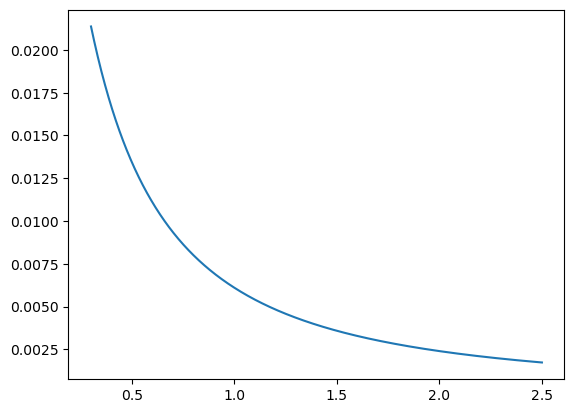

In [ ]:
f=None

#cosmo = FlatwCDM(H0=70, Om0=0.3, w0=-1.0)
cosmo = Cosmology(H0=70.0, Omega_dm0=0.3, Omega_b0=0.000, Omega_k0=0.0)

## DATA:
file_loc = "/global/u2/s/sriniva/Elliptical_lenses_data/Tae_NFW_halos/"
catalog_name = ".fits"
#file=file_loc+"Galaxy_catalog_10000_sigma_0.24.fits"

file=file_loc+catalog_name
hdul=fits.open(file)
data = Table(hdul[1].data)
data
#z_cluster=0.182
z_cluster=0.47
g_sigma=0.01

x = data['x1'].data
y = data['y1'].data
#phi = np.arctan2(y/x)
z = np.full()#np.append(data['z1'].data,data['z2'].data)
e_t = np.append(data['et_1'].data,data['et_2'].data)
e_1 = np.append(data['e1_1'].data,data['e2_1'].data)
e_2 = np.append(data['e1_2'].data,data['e2_2'].data)

gamma1 = e_t*(-1*np.cos(2*phi))#np.load(dir_loc_mcmc+"gamma1.npy").flatten()
gamma2 = e_t*(-1*np.sin(2*phi))#np.load(dir_loc_mcmc+"gamma2.npy").flatten()

x_arcsec = x/(cosmo.eval_da(z_cluster) * np.pi/180.0 * 1/3600)#np.load(dir_loc_mcmc+"x_arcsec.npy").flatten()
y_arcsec = y/(cosmo.eval_da(z_cluster) * np.pi/180.0 * 1/3600)#np.load(dir_loc_mcmc+"y_arcsec.npy").flatten()


#MCMC parameters:
params_key=["M200m","c200m","e",r"$\theta_{e}$ in degrees"]
ndim = len(params_key)
nwalkers = ndim*2+4
nsteps = 6000
nburns = 3000
np.random.seed(0)

limits=[[1.0E12,5.0E15],  # mdelta
       [0.0,20.0],     # cdelta
       [0.0001,0.99],   # e
       [0.0, 45.0]]    # theta_e #in degrees
z_cl=0.47
#z_gal=0.8
q_true=1.0 #default = 2/3 for the files in the same directory as this notebook
ell_true= 1*(1-q_true**2)/(1+q_true**2)
theta_e_true = 0.0
true_value=[1.0E15, 1.5/0.418, ell_true,theta_e_true]

'''
Axis ratio q:  0.6666666666666667
c:  3.890554441834905
r200_Mpc: 1.026773208537997
ARCSEC_TO_MPC:  0.00588784182755241
BOX_WIDTH_ARCSEC*ARCSEC_TO_MPC:  5.88784182755241
SIGMA_C=3.77988e+15
arcsec_per_pix:  10.0
'''
# PREP DATA:
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=z_cluster, 
                                                                                                                      sigma_c=3.77988e+15, method=1)


# CALL EMCEE
post, mean, err_plus, err_minus = emcee_wrapper(gamma1, gamma2, x_arcsec, y_arcsec,z_cl=z_cluster,
                                                params_key=params_key,limits=limits,true_value=true_value, ndim=ndim,nwalkers=nwalkers,nsteps=nsteps, nburn=nburns, filename=f)


